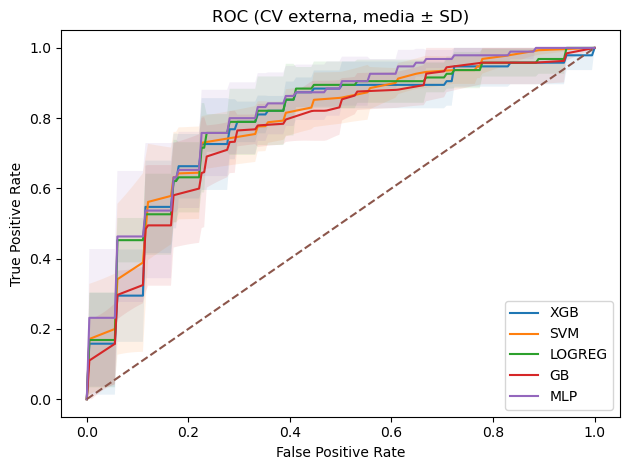

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
make_summary_qc_beta3.py
Consolida métricas de ./resultados_13_paper_qc_beta3 y genera tabla LaTeX y figuras.
"""
from pathlib import Path
import re, json, math
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, roc_curve, brier_score_loss
import matplotlib.pyplot as plt

BASE = Path("./resultados_13_paper_qc_beta3")
CLFS = ["xgb","svm","logreg","gb","mlp"]

def find_cols(df, y_cols=("y_true","target","label","y","gt"),
              p_cols=("y_score","proba_1","prob_1","p1","score","pred_proba","prob")):
    y = None; p = None
    for c in df.columns:
        if c.lower() in y_cols: y = c
        if c.lower() in p_cols: p = c
    # fallback heurísticos
    if y is None:
        # busca binaria 0/1
        for c in df.columns:
            vc = set(pd.unique(df[c].dropna().astype(str)))
            if vc.issubset({"0","1"}): y = c; break
    if p is None:
        # toma la columna float con mayor varianza en (0,1)
        floats = [c for c in df.columns if pd.api.types.is_float_dtype(df[c])]
        if floats:
            cand = pd.DataFrame({c: df[c].clip(0,1).var() for c in floats}, index=[0]).T
            p = cand.sort_values(0, ascending=False).index[0]
    if y is None or p is None:
        raise ValueError(f"No pude identificar columnas y_true/proba en {df.columns.tolist()}")
    return y, p

def youden_threshold(y, p):
    fpr, tpr, thr = roc_curve(y, p)
    j = tpr - fpr
    return thr[np.argmax(j)]

def load_fold_preds(fold_dir, clf):
    f = fold_dir / f"test_predictions_{clf}.csv"
    if not f.exists(): return None
    df = pd.read_csv(f)
    ycol, pcol = find_cols(df)
    y = df[ycol].astype(int).values
    p = df[pcol].astype(float).values
    return y, p

def summarize():
    rows = []
    roc_store = {clf: [] for clf in CLFS}
    for fold in sorted([d for d in BASE.glob("fold_*") if d.is_dir()],
                       key=lambda p: int(re.search(r"\d+", p.name).group())):
        for clf in CLFS:
            data = load_fold_preds(fold, clf)
            if data is None: continue
            y, p = data
            auc = roc_auc_score(y, p)
            thr = 0.5  # mantener decisión out-of-the-box (calibrado)
            yhat = (p >= thr).astype(int)
            balacc = balanced_accuracy_score(y, yhat)
            rows.append({"fold": fold.name, "clf": clf, "auc": auc, "balacc": balacc})
            fpr, tpr, _ = roc_curve(y, p)
            roc_store[clf].append((fpr, tpr))
    df = pd.DataFrame(rows)
    df.to_csv(BASE/"metrics_summary.csv", index=False)

    # Tabla LaTeX (media ± sd) por clasificador
    parts = []
    for clf, d in df.groupby("clf"):
        auc_mean, auc_sd = d["auc"].mean(), d["auc"].std(ddof=1)
        ba_mean,  ba_sd  = d["balacc"].mean(), d["balacc"].std(ddof=1)
        parts.append((clf, auc_mean, auc_sd, ba_mean, ba_sd))
    parts.sort(key=lambda x: x[1], reverse=True)
    tex = ["\\begin{tabular}{lcc}","\\toprule",
           "Modelo & ROC-AUC (media$\\pm$SD) & Balanced Acc (media$\\pm$SD) \\\\","\\midrule"]
    for clf, am, asd, bm, bsd in parts:
        tex.append(f"{clf.upper()} & {am:.3f}$\\pm${asd:.3f} & {bm:.3f}$\\pm${bsd:.3f} \\\\")
    tex += ["\\bottomrule","\\end{tabular}"]
    (BASE/"table_cv_performance.tex").write_text("\n".join(tex), encoding="utf-8")

    # ROC promedio ± SD (interpolado)
    plt.figure()
    grid = np.linspace(0,1,200)
    for clf in CLFS:
        if not roc_store[clf]: continue
        interp_tprs = []
        for fpr, tpr in roc_store[clf]:
            interp = np.interp(grid, fpr, tpr)
            interp[0] = 0.0
            interp_tprs.append(interp)
        mean_tpr = np.mean(interp_tprs, axis=0)
        std_tpr  = np.std(interp_tprs, axis=0)
        plt.plot(grid, mean_tpr, label=f"{clf.upper()}")
        plt.fill_between(grid, np.maximum(mean_tpr-std_tpr,0), np.minimum(mean_tpr+std_tpr,1), alpha=0.1)
    plt.plot([0,1],[0,1],linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC (CV externa, media ± SD)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(BASE/"roc_cv_mean_sd.png", dpi=300)



if __name__ == "__main__":
    summarize()


In [2]:
import joblib
import numpy as np
import pandas as pd
import torch
import re
import ast
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, brier_score_loss, roc_auc_score, average_precision_score
from sklearn.calibration import calibration_curve

# --- 1. CONFIGURACIÓN Y CARGA DE DATOS ---

# Añade la ruta a tus scripts si es necesario
sys.path.append('/home/diego/Escritorio/limpio/')
from models.convolutional_vae2 import ConvolutionalVAE
from serentipia9 import load_data, apply_normalization_params

# Estilo de las figuras
plt.rc("font", family="sans-serif", size=12)
plt.rc("axes", titlesize=14, labelsize=12, titleweight='bold')
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.rc("legend", fontsize=10)
sns.set_style("whitegrid")

# Rutas
RESULTS_DIR = Path("./resultados_13_paper_qc_beta3")
GLOBAL_TENSOR_PATH = Path("/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz")
METADATA_CSV = Path("/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv")
OUTPUT_FIG_DIR = RESULTS_DIR / "publication_figures"
OUTPUT_FIG_DIR.mkdir(exist_ok=True)

# Cargar argumentos del experimento
try:
    summary_file = next(RESULTS_DIR.glob("summary_metrics*.txt"))
    with open(summary_file, 'r') as f:
        content = f.read()
        dict_str_match = re.search(r"\{.*\}", content, re.DOTALL)
        run_args = ast.literal_eval(dict_str_match.group(0))
    print("✅ Argumentos del experimento cargados.")
except Exception as e:
    print(f"⚠️ No se pudieron cargar los argumentos, usando fallback: {e}")
    run_args = {
        'channels_to_use': [1, 2, 5], 'latent_dim': 512, 'num_conv_layers_encoder': 4,
        'decoder_type': 'convtranspose', 'vae_final_activation': 'tanh',
        'intermediate_fc_dim_vae': 'quarter', 'dropout_rate_vae': 0.2,
        'use_layernorm_vae_fc': False,
    }

# Cargar datos crudos
print("Cargando datos crudos...")
global_tensor_data, metadata_df_full = load_data(GLOBAL_TENSOR_PATH, METADATA_CSV)
cn_ad_df = metadata_df_full[metadata_df_full['ResearchGroup_Mapped'].isin(['CN', 'AD'])].reset_index(drop=True)
print("Datos cargados.")


# ==============================================================================
# --- 2. RECOLECCIÓN DE PREDICCIONES DE TODOS LOS PLIEGUES (CORREGIDO) ---
# ==============================================================================
print("\nRecalculando predicciones de los pliegues de prueba...")
all_probs, all_trues = [], []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for i in range(1, 6):
    fold_dir = RESULTS_DIR / f"fold_{i}"
    pipe = joblib.load(fold_dir / f"classifier_mlp_pipeline_fold_{i}.joblib")
    
    vae_model = ConvolutionalVAE(
        input_channels=len(run_args['channels_to_use']), latent_dim=run_args['latent_dim'],
        image_size=131, num_conv_layers_encoder=run_args['num_conv_layers_encoder'],
        decoder_type=run_args['decoder_type'], final_activation=run_args['vae_final_activation'],
        intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
        dropout_rate=run_args['dropout_rate_vae'], use_layernorm_fc=run_args['use_layernorm_vae_fc']
    ).to(device)
    
    vae_model.load_state_dict(torch.load(fold_dir / f"vae_model_fold_{i}.pt", map_location=device))
    vae_model.eval()
    norm_params = joblib.load(fold_dir / f"vae_norm_params.joblib")

    test_indices = np.load(fold_dir / "test_indices.npy")
    test_df_fold = cn_ad_df.iloc[test_indices]
    y_true_fold = (test_df_fold.ResearchGroup_Mapped == "AD").astype(int).values

    global_indices = test_df_fold['tensor_idx'].values
    tensor_test_orig = global_tensor_data[global_indices][:, run_args['channels_to_use'], :, :]
    tensor_test_norm = apply_normalization_params(tensor_test_orig, norm_params)
    
    with torch.no_grad():
        tensor_torch = torch.from_numpy(tensor_test_norm).float().to(device)
        recon_batch, mu, logvar, z = vae_model(tensor_torch)  # forward()
        X_latent_test = mu.cpu().numpy()  # usamos 'mu' porque latent_features_type == 'mu'


    # --- CORRECCIÓN PARA COMPATIBILIDAD CON MODELO PRE-ENTRENADO ---
    # Se debe construir el array con 514 features, como fue entrenado el pipe.
    # El manejo de 'Sex' vuelve a la versión simple (sin la columna 'sex_missing').
    metadata_test = test_df_fold[['Age', 'Sex']].copy()
    metadata_test['Sex'] = metadata_test['Sex'].map({'M': 0, 'F': 1})
    metadata_test['Sex'] = metadata_test['Sex'].fillna(-1)  # código aparte para missing

    #metadata_test['Sex'] = metadata_test['Sex'].map({'M': 0, 'F': 1}).fillna(0) # Rellena NaNs para mantener las 2 columnas
    
    # Combinar para obtener 512 (latente) + 2 (metadata) = 514 features
    X_test_combined = np.hstack([X_latent_test, metadata_test.values])
    
    # Ahora X_test_combined tiene la forma correcta (n_samples, 514)
    y_prob_fold = pipe.predict_proba(X_test_combined)[:, 1]
    
    all_probs.append(y_prob_fold)
    all_trues.append(y_true_fold)

y_prob = np.concatenate(all_probs)
y_true = np.concatenate(all_trues)
print("✅ Predicciones recolectadas (usando 514 features para compatibilidad).")



[INFO] [cuML] ➜ no disponible
[INFO] Usando dispositivo: cuda
[INFO] Cargando tensor global desde: /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz


¿GPU visible?: True
torch.cuda.is_available -> True
torch.version.cuda      -> 12.1
cupy GPU visible        -> True
¿GPU visible?: True
✅ Argumentos del experimento cargados.
Cargando datos crudos...


[INFO] Tensor global cargado. Forma: (431, 7, 131, 131)
[INFO] Cargando metadatos desde: /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv
[INFO] Metadatos cargados. Forma: (434, 33)


Datos cargados.

Recalculando predicciones de los pliegues de prueba...
✅ Predicciones recolectadas (usando 514 features para compatibilidad).


Realizando análisis de bootstrap (puede tardar un momento)...


[INFO] maxp pruned


✅ Análisis de bootstrap completado.


[INFO] cmap pruned
[INFO] kern dropped
[INFO] post pruned
[INFO] FFTM dropped
[INFO] GPOS pruned
[INFO] GSUB pruned
[INFO] name pruned
[INFO] glyf pruned
[INFO] Added gid0 to subset
[INFO] Added first four glyphs to subset
[INFO] Closing glyph list over 'GSUB': 6 glyphs before
[INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'nonmarkingreturn', 'space']
[INFO] Glyph IDs:   [0, 1, 2, 3, 36, 37]
[INFO] Closed glyph list over 'GSUB': 6 glyphs after
[INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'nonmarkingreturn', 'space']
[INFO] Glyph IDs:   [0, 1, 2, 3, 36, 37]
[INFO] Closing glyph list over 'glyf': 6 glyphs before
[INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'nonmarkingreturn', 'space']
[INFO] Glyph IDs:   [0, 1, 2, 3, 36, 37]
[INFO] Closed glyph list over 'glyf': 6 glyphs after
[INFO] Glyph names: ['.notdef', '.null', 'A', 'B', 'nonmarkingreturn', 'space']
[INFO] Glyph IDs:   [0, 1, 2, 3, 36, 37]
[INFO] Retaining 6 glyphs
[INFO] head subsetting not needed
[INFO] hhea subse

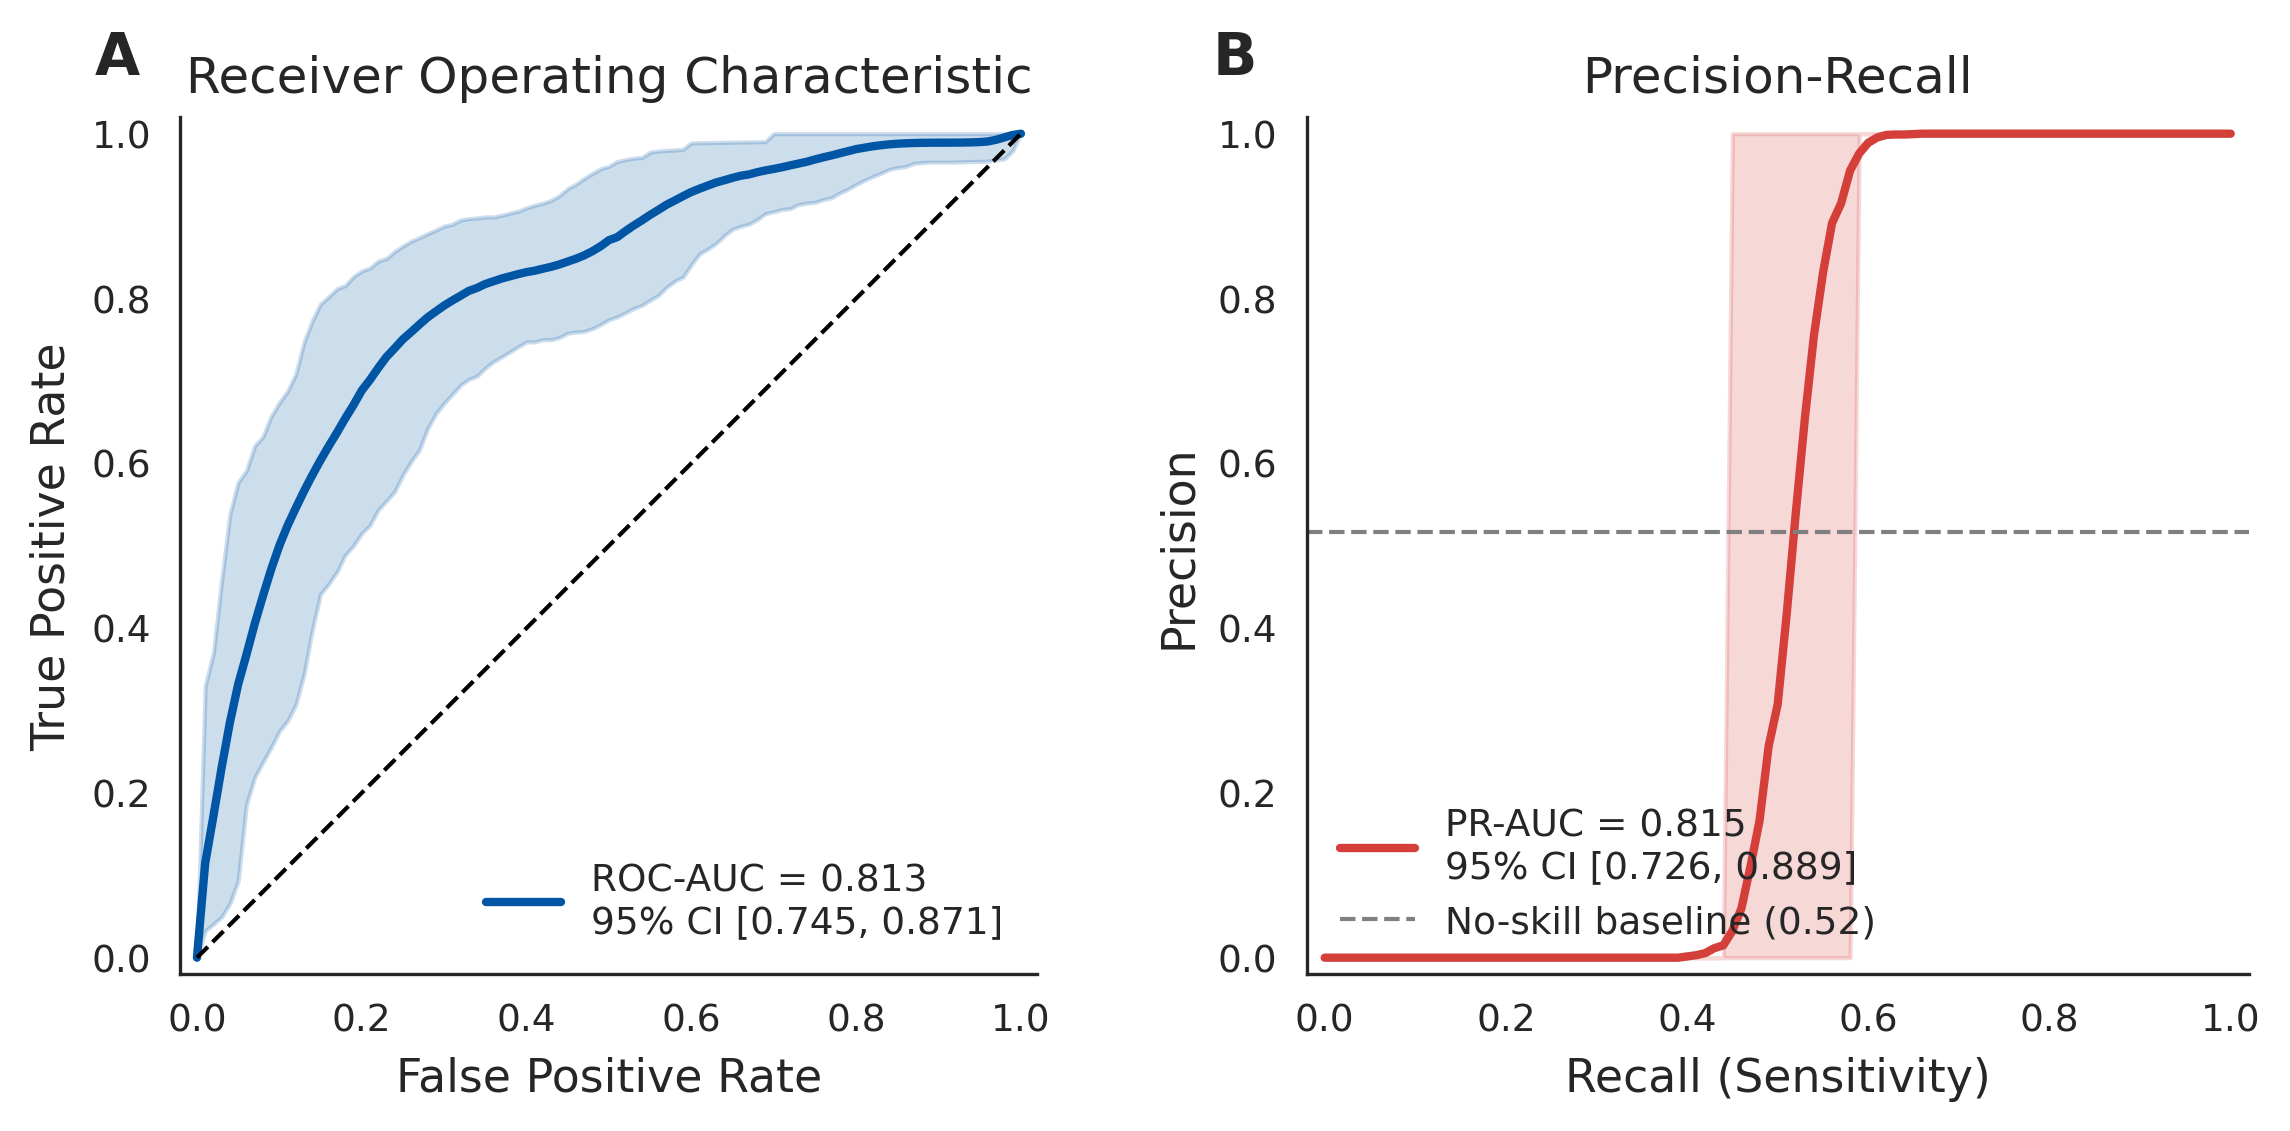


🎉 ¡Figura mejorada guardada en formatos PDF, PNG y SVG en: resultados_13_paper_qc_beta3/publication_figures/figure_performance_curves_publication!


In [3]:
# ==============================================================================
# --- 3. ANÁLISIS DE BOOTSTRAP Y VISUALIZACIÓN (VERSIÓN MEJORADA) ---
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_curve, precision_recall_curve,
                             roc_auc_score, average_precision_score)
from pathlib import Path
print("Realizando análisis de bootstrap (puede tardar un momento)...")
rng = np.random.default_rng(42)
B = 2000  # Número de remuestreos

# --- Lógica de Bootstrap para ROC y PR (se mantiene tu código original) ---
# --- Bootstrap para la curva ROC ---
fpr_grid = np.linspace(0, 1, 101)
tprs, aucs_roc = [], []
for _ in range(B):
    idx = rng.integers(0, len(y_true), len(y_true))
    if len(np.unique(y_true[idx])) < 2: continue
    fpr_i, tpr_i, _ = roc_curve(y_true[idx], y_prob[idx])
    tpr_interp = np.interp(fpr_grid, fpr_i, tpr_i)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    aucs_roc.append(roc_auc_score(y_true[idx], y_prob[idx]))

tprs = np.array(tprs)
tpr_mean = tprs.mean(0)
tpr_low = np.percentile(tprs, 2.5, 0)
tpr_high = np.percentile(tprs, 97.5, 0)
auc_roc_low, auc_roc_high = np.percentile(aucs_roc, [2.5, 97.5])

# --- Bootstrap para la curva PR ---
recall_grid = np.linspace(0, 1, 101)
precs, aucs_pr = [], []
for _ in range(B):
    idx = rng.integers(0, len(y_true), len(y_true))
    if len(np.unique(y_true[idx])) < 2: continue
    r, p, _ = precision_recall_curve(y_true[idx], y_prob[idx])
    p_interp = np.interp(recall_grid, r[::-1], p[::-1])
    precs.append(p_interp)
    aucs_pr.append(average_precision_score(y_true[idx], y_prob[idx]))

precs = np.array(precs)
prec_mean = precs.mean(0)
prec_low = np.percentile(precs, 2.5, 0)
prec_high = np.percentile(precs, 97.5, 0)
auc_pr_low, auc_pr_high = np.percentile(aucs_pr, [2.5, 97.5])

print("✅ Análisis de bootstrap completado.")

# ==============================================================================
# --- Creación de la figura final con estilo de publicación ---
# ==============================================================================

# 1. Definir estilo y colores
plt.style.use('default') # Reset a un estilo base
sns.set_style("white") # Fondo blanco sin grilla por defecto

import matplotlib as mpl

# Parámetros para un look profesional (calidad de revista)
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"], # Fuentes limpias
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.dpi": 300,
    "axes.spines.top": False, # Eliminar bordes superior y derecho
    "axes.spines.right": False,
    "pdf.fonttype": 42, # Embeber fuentes en PDF como TrueType
    "ps.fonttype": 42
})

# Paleta de colores profesional
COLOR_ROC = '#0055A4' # Azul Francia
COLOR_PR  = '#D43F3A' # Rojo Ladrillo

# 2. Creación de la figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4)) # Un poco más compacto

# --- Panel A y Panel B: preparar labels de las leyendas ---

auc_pooled_roc = roc_auc_score(y_true, y_prob)
roc_label = (f'ROC-AUC = {auc_pooled_roc:.3f}\n'
             f'95% CI [{auc_roc_low:.3f}, {auc_roc_high:.3f}]') # <-- CORREGIDO

auc_pooled_pr = average_precision_score(y_true, y_prob)
pr_label = (
    f'PR-AUC = {auc_pooled_pr:.3f}\n'
    f'95% CI [{auc_pr_low:.3f}, {auc_pr_high:.3f}]'
)




# --- Panel A: Curva ROC ---
ax1.plot(fpr_grid, tpr_mean, color=COLOR_ROC, lw=2, label=roc_label) # <-- AHORA FUNCIONA
ax1.fill_between(fpr_grid, tpr_low, tpr_high, color=COLOR_ROC, alpha=0.2)
ax1.set_aspect('equal', 'box')
ax1.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
ax1.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02],
        xlabel='False Positive Rate', ylabel='True Positive Rate',
        title='Receiver Operating Characteristic')
ax1.legend(loc="lower right", frameon=False)
ax1.text(-0.1, 1.05, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold')


# --- Panel B: Curva PR ---
baseline = np.sum(y_true) / len(y_true)
ax2.plot(recall_grid, prec_mean, color=COLOR_PR, lw=2, label=pr_label)
ax2.fill_between(recall_grid, prec_low, prec_high, color=COLOR_PR, alpha=0.2)
ax2.axhline(baseline, color='grey', linestyle='--', lw=1, label=f'No-skill baseline ({baseline:.2f})')
ax2.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02],
        xlabel='Recall (Sensitivity)', ylabel='Precision',
        title='Precision-Recall')
ax2.legend(loc="lower left", frameon=False)
ax2.text(-0.1, 1.05, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold')

# 3. Guardar en múltiples formatos (vectorial y raster) y mostrar
fig.tight_layout(pad=1.5)
fig_path_base = OUTPUT_FIG_DIR / "figure_performance_curves_publication"

# Guardar en los formatos que ya tenías
plt.savefig(f"{fig_path_base}.pdf", bbox_inches='tight')
plt.savefig(f"{fig_path_base}.png", dpi=300, bbox_inches='tight')

# --- LÍNEA NUEVA AÑADIDA ---
# Guardar en formato SVG
plt.savefig(f"{fig_path_base}.svg", bbox_inches='tight')

plt.show()

print(f"\n🎉 ¡Figura mejorada guardada en formatos PDF, PNG y SVG en: {fig_path_base}!")

In [4]:
# ===================================================================
# --- 1. SETUP, IMPORTS Y CARGA DE DATOS (VERSIÓN UNIFICADA) ---
# ===================================================================

import joblib
import json
import glob
import re
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import seaborn as sns
import torch
from pathlib import Path
import umap  # pip install umap-learn
import ast   # para evaluar strings de forma segura

# -------------------------
# Importaciones de tu repo
# -------------------------
import sys
sys.path.append('/home/diego/Escritorio/limpio/')
from models.convolutional_vae2 import ConvolutionalVAE
from serentipia9 import load_data, apply_normalization_params

# -------------------------
# Estilo figuras
# -------------------------
plt.rc("font", family="sans-serif", size=12)
plt.rc("axes", titlesize=14, labelsize=12, titleweight='bold')
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.rc("legend", fontsize=10)
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# -------------------------
# Rutas (UNIFICADAS)
# MUY IMPORTANTE: usamos el MISMO RESULTS_DIR que en las celdas anteriores
# para que todo salga del mismo experimento qc_beta3.
# -------------------------
RESULTS_DIR = Path("./resultados_13_paper_qc_beta3")

GLOBAL_TENSOR_PATH = Path(
    "/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz"
)
METADATA_CSV = Path("/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv")

# OJO: no volvemos a crear OUTPUT_FIG_DIR si ya existe en memoria.
# Pero si esta celda se corre independiente, lo recreamos igual.
OUTPUT_FIG_DIR = RESULTS_DIR / "publication_figures"
OUTPUT_FIG_DIR.mkdir(exist_ok=True)

# -------------------------
# Cargar artefactos del experimento
# -------------------------
try:
    # Buscamos el CSV de métricas cross-val
    csv_files = list(RESULTS_DIR.glob("all_folds_metrics_MULTI_*.csv"))
    if not csv_files:
        raise FileNotFoundError("No se encontró el archivo de métricas CSV en RESULTS_DIR.")
    CSV_PATH = csv_files[0]

    # Extraer sufijo de run para encontrar el history correspondiente
    match = re.search(r"all_folds_metrics_MULTI_(.*)\.csv", CSV_PATH.name)
    if not match:
        raise ValueError("No se pudo extraer el sufijo del experimento del nombre del archivo.")
    SUFFIX = match.group(1)

    HIST_PATH = RESULTS_DIR / f"all_folds_vae_training_history_{SUFFIX}.joblib"

    print(f"✅ Archivos encontrados para el experimento:\n    {SUFFIX}")

    # Cargar métricas CV y el history de entrenamiento del VAE
    metrics_df = pd.read_csv(CSV_PATH)
    histories = joblib.load(HIST_PATH)

    # Elegir el mejor clasificador según AUC promedio
    best_clf_name = metrics_df.groupby('actual_classifier_type')['auc'].mean().idxmax()
    print(f"🏆 Mejor clasificador identificado: '{best_clf_name}' (basado en 'auc' promedio)")

except (FileNotFoundError, IndexError, ValueError) as e:
    print(f"❌ ERROR al cargar artefactos del experimento: {e}")
    metrics_df, histories, best_clf_name = None, None, None

# -------------------------
# Cargar tensor y metadatos (para UMAP, QC latente, etc.)
# -------------------------
if metrics_df is not None:
    print("\nCargando tensor y metadatos para análisis UMAP / QC latente...")
    global_tensor_data, metadata_df_full = load_data(GLOBAL_TENSOR_PATH, METADATA_CSV)
    print("Datos crudos cargados exitosamente.")


[INFO] Cargando tensor global desde: /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz


✅ Archivos encontrados para el experimento:
    xgb_vaeconvtranspose4l_ld256_beta4.6_normzscore_offdiag_ch3sel_intFCquarter_drop0.2_ln0_outer5x1_scoreroc_auc
🏆 Mejor clasificador identificado: 'logreg' (basado en 'auc' promedio)

Cargando tensor y metadatos para análisis UMAP / QC latente...


[INFO] Tensor global cargado. Forma: (431, 7, 131, 131)
[INFO] Cargando metadatos desde: /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv
[INFO] Metadatos cargados. Forma: (434, 33)


Datos crudos cargados exitosamente.



--- Generando embeddings latentes de los datos de TEST de cada fold ---
✅ Argumentos cargados: Canales=[1, 2, 5], Dim Latente=256
✅ Embeddings de test generados para todos los folds.


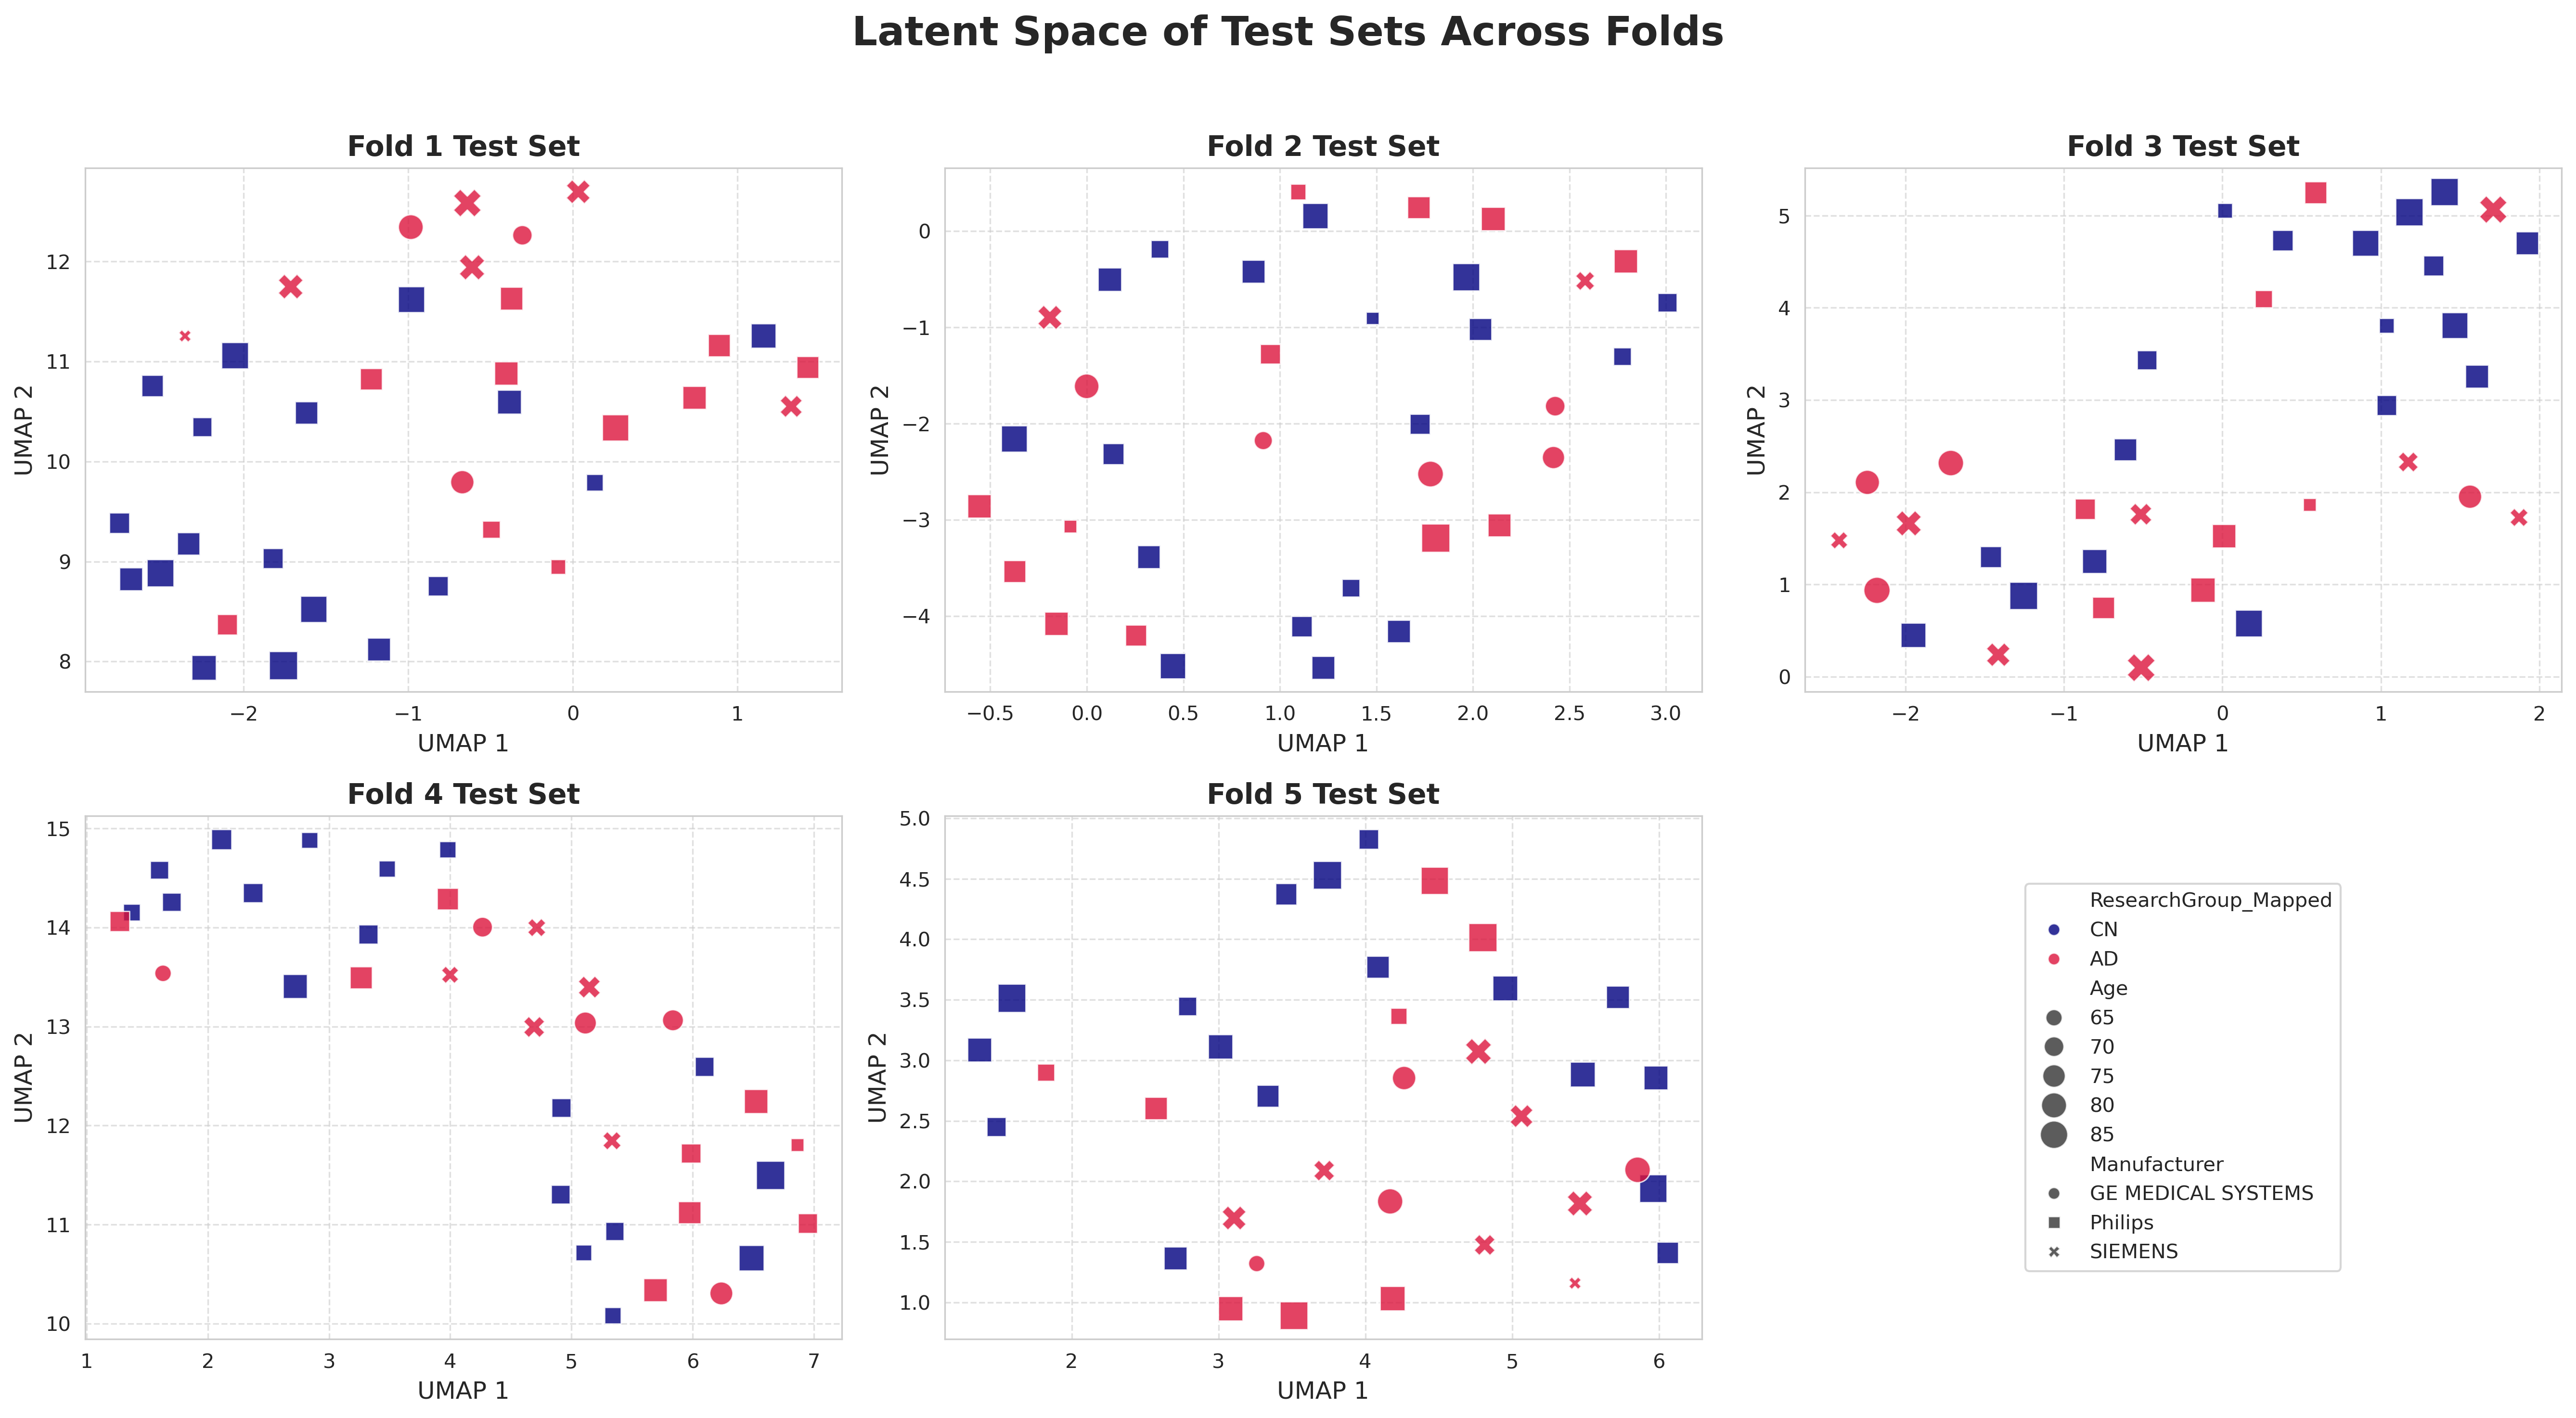

In [5]:
# ==============================================================================
# --- 3. Figura 2: Análisis del Espacio Latente por Fold (CORREGIDO) ---
# ==============================================================================
import logging
import umap

# AJUSTE: Silenciar logs ruidosos al guardar figuras
logging.getLogger('fontTools.subset').setLevel(logging.ERROR)

if 'metrics_df' in locals() and metrics_df is not None and 'global_tensor_data' in locals():
    print("\n--- Generando embeddings latentes de los datos de TEST de cada fold ---")

    # Carga de argumentos y generación de embeddings (Versión Limpia, sin duplicados)
    try:
        summary_files = list(RESULTS_DIR.glob("summary_metrics*.txt"))
        with open(summary_files[0], 'r') as f:
            run_args = ast.literal_eval(re.search(r"\{.*\}", f.read(), re.DOTALL).group(0))
        print(f"✅ Argumentos cargados: Canales={run_args.get('channels_to_use')}, Dim Latente={run_args.get('latent_dim')}")
    except Exception as e:
        print(f"⚠️ No se pudo cargar 'run_args' ({e}). Usando configuración de fallback.")
        run_args = {'channels_to_use':[1,2,5],'latent_dim':512,'num_conv_layers_encoder':4,
                    'decoder_type':'convtranspose','vae_final_activation':'tanh',
                    'intermediate_fc_dim_vae':'quarter','dropout_rate_vae':0.2,
                    'use_layernorm_vae_fc':False}

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    all_fold_data = []
    cn_ad_df = metadata_df_full[metadata_df_full['ResearchGroup_Mapped'].isin(['CN','AD'])].reset_index(drop=True)

    for i in range(1, 6):
        fold_dir = RESULTS_DIR / f"fold_{i}"
        vae = ConvolutionalVAE(
            input_channels=len(run_args['channels_to_use']), latent_dim=run_args['latent_dim'], image_size=131,
            num_conv_layers_encoder=run_args['num_conv_layers_encoder'], decoder_type=run_args['decoder_type'],
            final_activation=run_args['vae_final_activation'], intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
            dropout_rate=run_args['dropout_rate_vae'], use_layernorm_fc=run_args['use_layernorm_vae_fc']
        ).to(device)
        vae.load_state_dict(torch.load(fold_dir / f"vae_model_fold_{i}.pt", map_location=device))
        vae.eval()

        test_idx = np.load(fold_dir / "test_indices.npy")
        norm_params = joblib.load(fold_dir / "vae_norm_params.joblib")
        df_fold = cn_ad_df.iloc[test_idx].copy()

        tens = global_tensor_data[df_fold['tensor_idx'].values][:, run_args['channels_to_use'], :, :]
        tens = apply_normalization_params(tens, norm_params)

        with torch.no_grad():
                    # Definir el tensor 'tens_torch' antes de usarlo
                    tens_torch = torch.from_numpy(tens).float().to(device) # <-- LÍNEA AÑADIDA
                    
                    # Usar .encode() es más limpio ya que solo necesitas 'mu'
                    mu, _ = vae.encode(tens_torch)
                    df_fold['embeddings'] = list(mu.cpu().numpy())


        all_fold_data.append(df_fold)
    print("✅ Embeddings de test generados para todos los folds.")

    # --- Plot UMAP por fold ---
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("Latent Space of Test Sets Across Folds", fontsize=20, weight='bold')
    axes_flat = axes.flatten()
    
    # Se crea el diccionario de marcadores con los nombres limpios
    full_test_df = pd.concat(all_fold_data)
    full_test_df['Manufacturer'] = (full_test_df['Manufacturer']
                                    .str.replace(' Medical Systems','').str.replace(' Healthcare','')
                                    .fillna('Unknown'))
    mans = sorted(full_test_df['Manufacturer'].unique())
    markers = ["o","s","X","P","D","^","v"]
    marker_map = {m: markers[i % len(markers)] for i, m in enumerate(mans)}

    for i, df_fold in enumerate(all_fold_data):
        ax = axes_flat[i]
        reducer = umap.UMAP(n_neighbors=10, min_dist=0.2, metric='cosine', random_state=42)
        emb2d = reducer.fit_transform(np.vstack(df_fold['embeddings'].values))
        
        plot_df = pd.DataFrame(emb2d, columns=['UMAP 1','UMAP 2'])
        plot_df = pd.concat([plot_df, df_fold.reset_index(drop=True)], axis=1)

        # --- CORRECCIÓN APLICADA AQUÍ ---
        # Limpia la columna 'Manufacturer' en el DataFrame de ploteo para que coincida
        # con las claves del diccionario 'marker_map'.
        plot_df['Manufacturer'] = (plot_df['Manufacturer']
                                     .str.replace(' Medical Systems', '')
                                     .str.replace(' Healthcare', '')
                                     .fillna('Unknown'))

        sns.scatterplot(data=plot_df, x='UMAP 1', y='UMAP 2', hue='ResearchGroup_Mapped', 
                        style='Manufacturer', size='Age', palette={'CN':'navy','AD':'crimson'}, 
                        sizes=(40,200), style_order=mans, markers=marker_map, alpha=0.8, ax=ax)
        ax.set_title(f"Fold {i+1} Test Set"); ax.grid(True, linestyle='--', alpha=0.6); ax.legend().remove()

    legend_ax = axes_flat[-1]; legend_ax.axis('off')
    handles, labels = axes_flat[0].get_legend_handles_labels()
    legend_ax.legend(handles, labels, ncol=1, loc='center')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(OUTPUT_FIG_DIR / "figure2_umap_per_fold_detailed.png", dpi=300, bbox_inches='tight')
    plt.savefig(OUTPUT_FIG_DIR / "figure2_umap_per_fold_detailed.pdf", bbox_inches='tight')
    #guardar en svg
    plt.savefig(OUTPUT_FIG_DIR / "figure2_umap_per_fold_detailed.svg", bbox_inches='tight')
    plt.show()

else:
    print("⚠️ No se ejecutó el análisis UMAP porque los datos no fueron cargados previamente.")

In [6]:
# ==============================================================================
# --- 4. QC del Espacio Latente y Exportación a LaTeX (CORREGIDO) ---
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

def participation_ratio(evals):
    ev = np.asarray(evals, dtype=float)
    if ev.ndim != 1 or np.all(ev <= 0): return np.nan
    s1, s2 = ev.sum(), np.square(ev).sum()
    return (s1*s1)/s2 if s2 > 0 else np.nan

def clean_manufacturer(s):
    if pd.isna(s): return 'Unknown'
    return str(s).replace(' Medical Systems','').replace(' Healthcare','').strip()

assert 'all_fold_data' in globals(), "Falta all_fold_data (corré la celda de UMAP primero)."

rows = []
for fold_i, df_fold in enumerate(all_fold_data, start=1):
    Z = np.vstack(df_fold['embeddings'].values)
    y = df_fold['ResearchGroup_Mapped'].values
    site = pd.Series(df_fold['Site3'].map(clean_manufacturer))

    Zstd = StandardScaler().fit_transform(Z)
    ncomp = min(20, Zstd.shape[1], max(2, Zstd.shape[0]-1))
    pca = PCA(n_components=ncomp, svd_solver="full", random_state=42)
    Zp = pca.fit_transform(Zstd)

    try: sil = silhouette_score(Zp, y, metric='euclidean')
    except Exception: sil = np.nan

    ev = pca.explained_variance_
    pr = participation_ratio(ev)
    dims90 = int(np.searchsorted(np.cumsum(pca.explained_variance_ratio_), 0.90) + 1)
    
    keep = site.map(site.value_counts()) >= 2
    acc = np.nan
    if keep.sum() >= 6 and site[keep].nunique() >= 2:
        cv = StratifiedKFold(n_splits=max(2, min(5, pd.Series(site[keep]).value_counts().min())), shuffle=True, random_state=42)
        acc = cross_val_score(KNeighborsClassifier(n_neighbors=5), Zp[keep.values], site[keep].values, cv=cv, scoring='accuracy').mean()

    rows.append({
        "Fold": fold_i, "Class Separability (Silhouette)": sil, "Confounder Effect (Site Acc.)": acc,
        "Effective Dimensions (PR)": pr, "PCA Dims (90% Var)": dims90
    })

qc_df = pd.DataFrame(rows)
qc_df.to_csv(OUTPUT_FIG_DIR / "qc_latent_space_metrics.csv", index=False)
print(f"✅ qc_df listo y guardado en: {OUTPUT_FIG_DIR / 'qc_latent_space_metrics.csv'}")

# --- AJUSTE: Exportar la tabla a formato LaTeX para el paper ---
cols = ["Class Separability (Silhouette)", "Confounder Effect (Site Acc.)", "Effective Dimensions (PR)", "PCA Dims (90% Var)"]
qc_df_round = qc_df.copy()
qc_df_round[cols[:-1]] = qc_df_round[cols[:-1]].astype(float).round(3)
qc_df_round[cols[-1]] = qc_df_round[cols[-1]].astype(int)

tex_path = OUTPUT_FIG_DIR / "table_qc_latent_space.tex"
with open(tex_path, "w") as f:
    # Formato 'ccccc' para centrar las 5 columnas en LaTeX
    f.write(qc_df_round.to_latex(index=False, escape=False, column_format="ccccc"))
print(f"📄 Tabla LaTeX guardada en: {tex_path}")

# Muestra el DataFrame original en la salida del notebook
qc_df

✅ qc_df listo y guardado en: resultados_13_paper_qc_beta3/publication_figures/qc_latent_space_metrics.csv
📄 Tabla LaTeX guardada en: resultados_13_paper_qc_beta3/publication_figures/table_qc_latent_space.tex


,Fold,Class Separability (Silhouette),Confounder Effect (Site Acc.),Effective Dimensions (PR),PCA Dims (90% Var)
0,1,0.036928,0.403846,13.451608,20
1,2,0.006512,0.178571,13.572933,19
2,3,0.036215,0.427778,11.550919,19
3,4,0.027416,0.252747,11.630262,19
4,5,0.009743,0.125000,13.200460,19


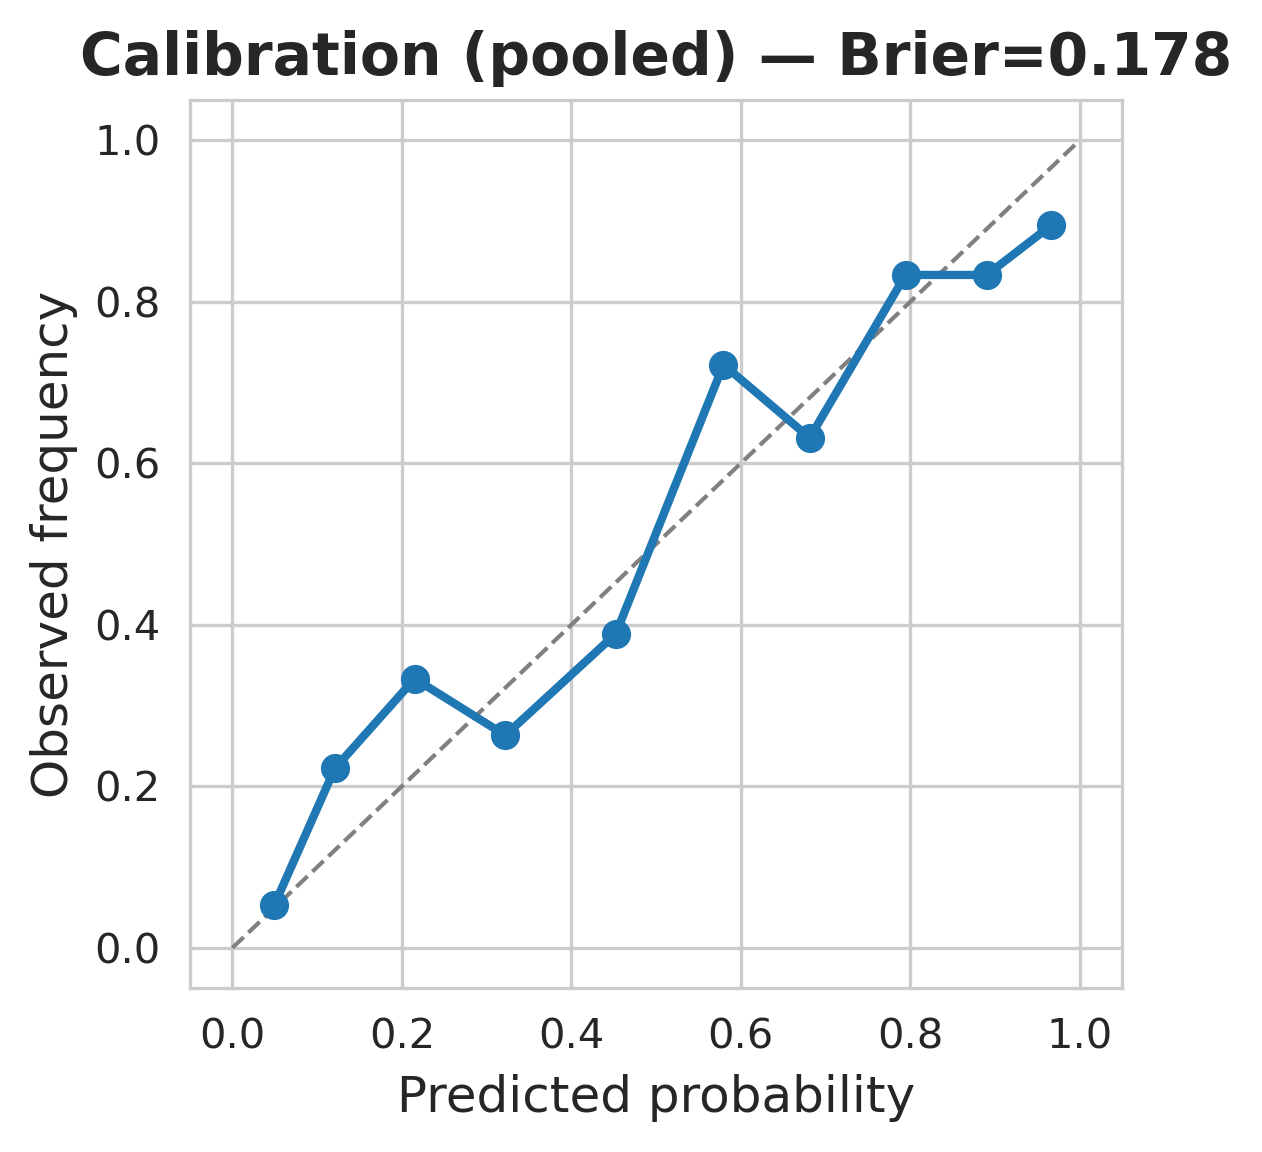

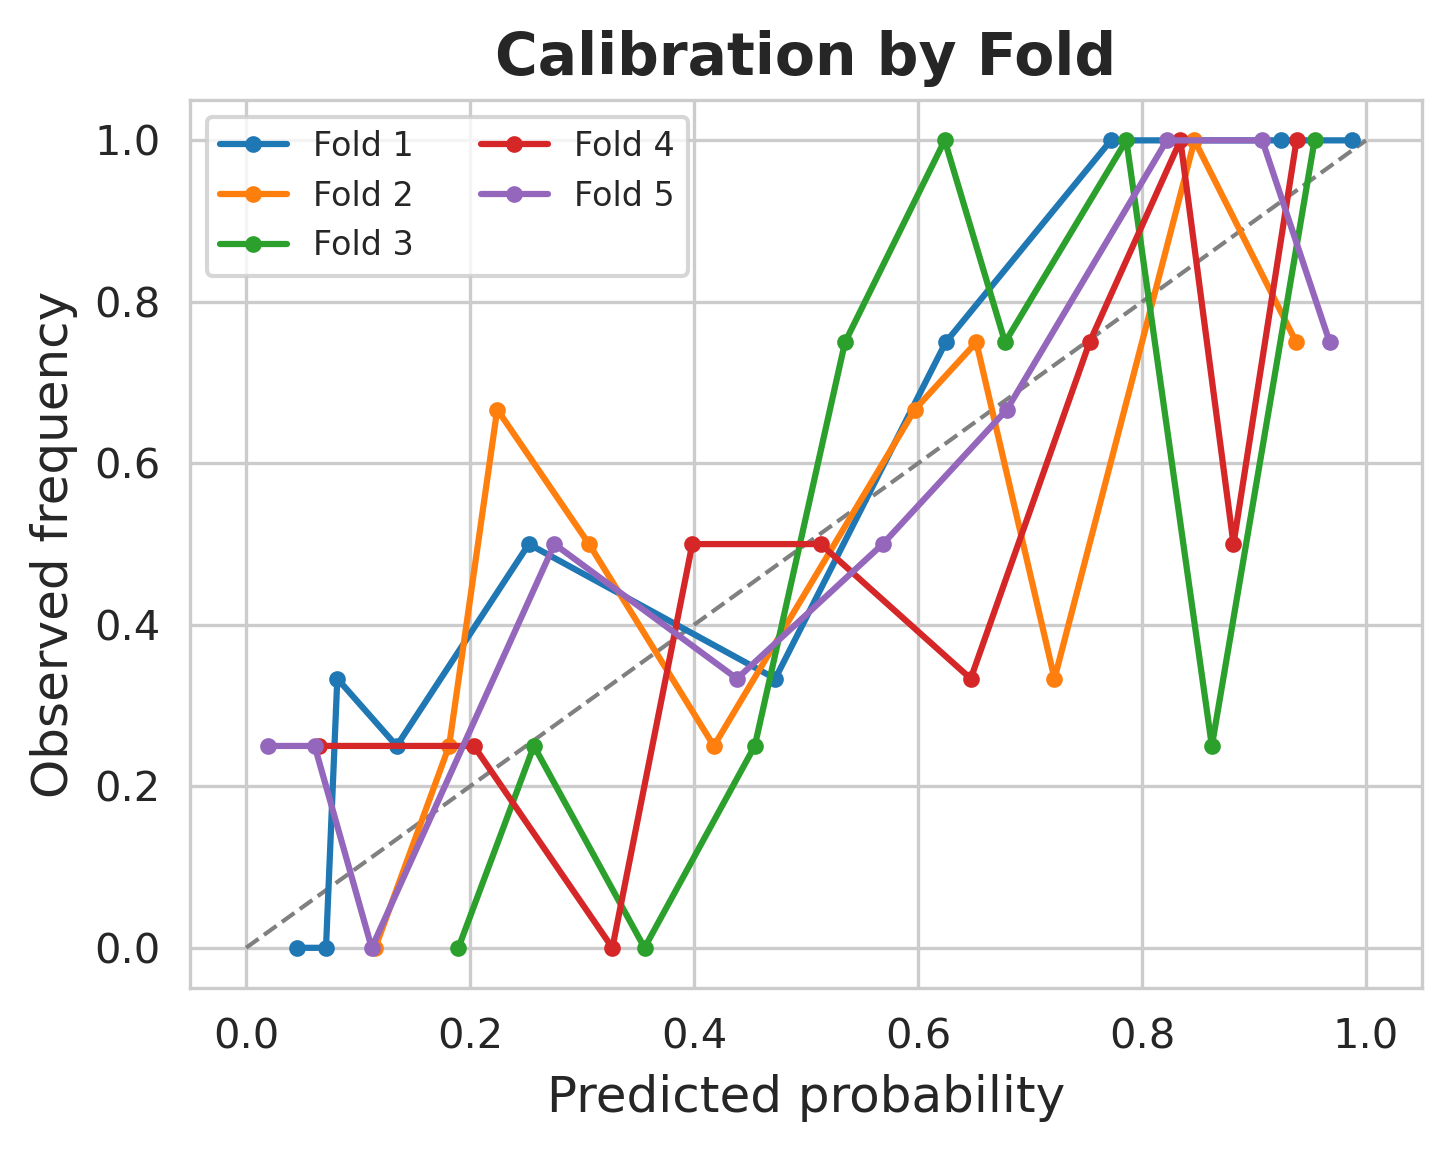

In [7]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# Pooled
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='quantile')
brier = brier_score_loss(y_true, y_prob)

fig, ax = plt.subplots(figsize=(4,4))
ax.plot([0,1],[0,1],'--',lw=1, color='grey')
ax.plot(prob_pred, prob_true, marker='o', lw=2)
ax.set(xlabel='Predicted probability', ylabel='Observed frequency',
       title=f'Calibration (pooled) — Brier={brier:.3f}')
fig.tight_layout()
fig.savefig(OUTPUT_FIG_DIR/'figure_calibration_pooled.pdf', bbox_inches='tight')
fig.savefig(OUTPUT_FIG_DIR/'figure_calibration_pooled.png', dpi=300, bbox_inches='tight')
plt.show()

# Por fold (overlay)
fig, ax = plt.subplots(figsize=(5,4))
ax.plot([0,1],[0,1],'--',lw=1, color='grey')
for i, (p, t) in enumerate(zip(all_probs, all_trues), start=1):
    pt, pp = calibration_curve(t, p, n_bins=10, strategy='quantile')
    ax.plot(pp, pt, marker='.', lw=1.5, label=f'Fold {i}')
ax.set(xlabel='Predicted probability', ylabel='Observed frequency', title='Calibration by Fold')
ax.legend(ncol=2, fontsize=8)
fig.tight_layout()
fig.savefig(OUTPUT_FIG_DIR/'figure_calibration_by_fold.pdf', bbox_inches='tight')
fig.savefig(OUTPUT_FIG_DIR/'figure_calibration_by_fold.png', dpi=300, bbox_inches='tight')
plt.show()


In [8]:
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

rows = []
for i, (p, t) in enumerate(zip(all_probs, all_trues), start=1):
    rows.append({
        "Fold": i,
        "N_test": len(t),
        "N_AD_test": int(t.sum()),
        "N_CN_test": int((1-t).sum()),
        "ROC_AUC": roc_auc_score(t, p),
        "PR_AUC": average_precision_score(t, p),
        "Brier": brier_score_loss(t, p)
    })

# pooled/out-of-fold global
rows.append({
    "Fold": "Pooled",
    "N_test": len(y_true),
    "N_AD_test": int(y_true.sum()),
    "N_CN_test": int((1-y_true).sum()),
    "ROC_AUC": roc_auc_score(y_true, y_prob),
    "PR_AUC": average_precision_score(y_true, y_prob),
    "Brier": brier_score_loss(y_true, y_prob)
})

perf_df = pd.DataFrame(rows)
perf_df_rounded = perf_df.copy()
perf_df_rounded[["ROC_AUC","PR_AUC","Brier"]] = perf_df_rounded[["ROC_AUC","PR_AUC","Brier"]].round(3)

display(perf_df_rounded)

# opcional export a .csv y .tex igual que hiciste con qc_df:
perf_df_rounded.to_csv(OUTPUT_FIG_DIR / "table_performance_by_fold.csv", index=False)

with open(OUTPUT_FIG_DIR / "table_performance_by_fold.tex", "w") as f:
    f.write(perf_df_rounded.to_latex(index=False, escape=False, column_format="ccccccc"))


,Fold,N_test,N_AD_test,N_CN_test,ROC_AUC,PR_AUC,Brier
0,1,37,19,18,0.921,0.934,0.130
1,2,37,19,18,0.740,0.709,0.212
2,3,37,19,18,0.825,0.812,0.175
3,4,37,19,18,0.798,0.813,0.189
4,5,36,19,17,0.805,0.819,0.186
5,Pooled,184,95,89,0.813,0.815,0.178


In [9]:
site_summary_rows = []

for i in range(1, 6):
    fold_dir = RESULTS_DIR / f"fold_{i}"
    test_idx  = np.load(fold_dir / "test_indices.npy")
    #train_idx = np.load(fold_dir / "train_indices.npy")  # <-- si lo tenés guardado
    # Celda In[7] - Alternativa
    all_cn_ad_indices = np.arange(len(cn_ad_df)) # Total de índices CN/AD
    train_idx = np.setdiff1d(all_cn_ad_indices, test_idx, assume_unique=True) # Índices que NO están en test

    df_train = cn_ad_df.iloc[train_idx].copy()
    df_test  = cn_ad_df.iloc[test_idx].copy()

    # limpiar fabricante igual que antes
    def clean_manu(x):
        if pd.isna(x): return 'Unknown'
        return str(x).replace(' Medical Systems','').replace(' Healthcare','').strip()

    df_train['Manufacturer_clean'] = df_train['Manufacturer'].map(clean_manu)
    df_test['Manufacturer_clean']  = df_test['Manufacturer'].map(clean_manu)
    # En Celda [7]
    df_train['site_clean'] = df_train['Site3'].astype(str).fillna('Unknown')
    df_test['site_clean']  = df_test['Site3'].astype(str).fillna('Unknown')

    # ... y más abajo ...
    site_counts_train = df_train['site_clean'].value_counts(normalize=True)
    site_counts_test  = df_test['site_clean'].value_counts(normalize=True)

    # stats numéricas
    age_train_mean = df_train['Age'].mean()
    age_test_mean  = df_test['Age'].mean()

    # proporción AD
    ad_train = (df_train['ResearchGroup_Mapped'] == 'AD').mean()
    ad_test  = (df_test['ResearchGroup_Mapped'] == 'AD').mean()

    # top sitio en test que casi no aparece en train
    site_counts_train = df_train['Manufacturer_clean'].value_counts(normalize=True)
    site_counts_test  = df_test['Manufacturer_clean'].value_counts(normalize=True)

    site_counts_train = df_train['site_clean'].value_counts(normalize=True)
    site_counts_test  = df_test['site_clean'].value_counts(normalize=True)

    # medimos “shift máximo” = sitio más sobrerrepresentado en test vs train
    common_sites = set(site_counts_train.index) | set(site_counts_test.index)
    max_site_shift = max(
        abs(site_counts_test.get(s,0) - site_counts_train.get(s,0))
        for s in common_sites
    )

    site_summary_rows.append({
        "Fold": i,
        "N_train": len(df_train),
        "N_test": len(df_test),
        "Mean_Age_train": round(age_train_mean,1),
        "Mean_Age_test": round(age_test_mean,1),
        "AD_frac_train": round(ad_train,2),
        "AD_frac_test": round(ad_test,2),
        "Max_site_shift(abs%)": round(max_site_shift,2)
    })

site_shift_df = pd.DataFrame(site_summary_rows)
display(site_shift_df)

site_shift_df.to_csv(OUTPUT_FIG_DIR / "table_domain_shift_by_fold.csv", index=False)


,Fold,N_train,N_test,Mean_Age_train,Mean_Age_test,AD_frac_train,AD_frac_test,Max_site_shift(abs%)
0,1,147,37,74.1,75.4,0.52,0.51,0.08
1,2,147,37,74.8,72.6,0.52,0.51,0.06
2,3,147,37,74.5,73.8,0.52,0.51,0.08
3,4,147,37,74.6,73.4,0.52,0.51,0.06
4,5,148,36,73.8,76.6,0.51,0.53,0.09


In [10]:
from sklearn.metrics import confusion_matrix

thresholds = np.linspace(0,1,101)
rows_thr = []
for thr in thresholds:
    y_hat = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    sens = tp / (tp+fn) if (tp+fn)>0 else np.nan   # recall AD
    spec = tn / (tn+fp) if (tn+fp)>0 else np.nan   # recall CN
    rows_thr.append({"thr":thr, "sensitivity":sens, "specificity":spec})

thr_df = pd.DataFrame(rows_thr)

# Ejemplo: threshold mínimo que logra sensitivity >= 0.90
target_sens = 0.90
cand = thr_df[thr_df["sensitivity"] >= target_sens].sort_values("thr").head(1)
display(cand)


,thr,sensitivity,specificity
0,0.0,1.0,0.0


In [11]:
from sklearn.metrics import confusion_matrix

def metrics_at_threshold(y_true, y_prob, thr):
    y_hat = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    sens = tp / (tp+fn) if (tp+fn)>0 else np.nan   # recall AD
    spec = tn / (tn+fp) if (tn+fp)>0 else np.nan   # recall CN
    ppv  = tp / (tp+fp) if (tp+fp)>0 else np.nan   # precision (AD predicted realmente AD)
    npv  = tn / (tn+fn) if (tn+fn)>0 else np.nan
    fpr  = fp / (fp+tn) if (fp+tn)>0 else np.nan
    fnr  = fn / (fn+tp) if (fn+tp)>0 else np.nan
    return {
        "thr": thr,
        "sensitivity": sens,
        "specificity": spec,
        "PPV": ppv,
        "NPV": npv,
        "FPR": fpr,
        "FNR": fnr
    }

# 1) elegimos un punto operativo clínico: alta sensibilidad (screening)
target_sens = 0.90
thr_candidates = []
for thr in np.linspace(0,1,1001):
    m = metrics_at_threshold(y_true, y_prob, thr)
    if m["sensitivity"] >= target_sens:
        thr_candidates.append(m)
        
if len(thr_candidates) > 0:
    best_operating_point = sorted(thr_candidates, key=lambda d: d["thr"])[0]
else:
    # fallback: mejor Youden J
    youdens = []
    for thr in np.linspace(0,1,1001):
        m = metrics_at_threshold(y_true, y_prob, thr)
        if not np.isnan(m["sensitivity"]) and not np.isnan(m["specificity"]):
            youdens.append((m["sensitivity"] + m["specificity"] - 1, m))
    best_operating_point = sorted(youdens, key=lambda x: x[0], reverse=True)[0][1]

print("=== Operating point sugerido ===")
for k,v in best_operating_point.items():
    print(f"{k}: {v:.3f}")
 

=== Operating point sugerido ===
thr: 0.000
sensitivity: 1.000
specificity: 0.000
PPV: 0.516
NPV: nan
FPR: 1.000
FNR: 0.000


In [12]:
def pick_operating_point(y_true, y_prob, target_sens=0.85):
    grid = np.linspace(0,1,1001)
    cands = []
    for thr in grid:
        m = metrics_at_threshold(y_true, y_prob, thr)
        if m["sensitivity"] >= target_sens:
            cands.append(m)
    if cands:
        # el de mayor especificidad dentro de esa sensibilidad mínima
        return sorted(cands, key=lambda d: d["specificity"], reverse=True)[0]
    # fallback: mejor Youden
    best_j = None
    for thr in grid:
        m = metrics_at_threshold(y_true, y_prob, thr)
        if not np.isnan(m["sensitivity"]) and not np.isnan(m["specificity"]):
            J = m["sensitivity"] + m["specificity"] - 1
            if (best_j is None) or (J > best_j[0]):
                best_j = (J, m)
    return best_j[1]

op85 = pick_operating_point(y_true, y_prob, target_sens=0.85)
print(">>> Operating point (sens>=0.85, best spec):")
for k,v in op85.items():
    print(f"{k}: {v:.3f}")


>>> Operating point (sens>=0.85, best spec):
thr: 0.278
sensitivity: 0.863
specificity: 0.506
PPV: 0.651
NPV: 0.776
FPR: 0.494
FNR: 0.137



--- Correlación (Spearman) entre Rendimiento y Desajustes (N=5) ---
AUC vs. Max Site Shift:     0.632
AUC vs. Latent Site Leakage: 0.600


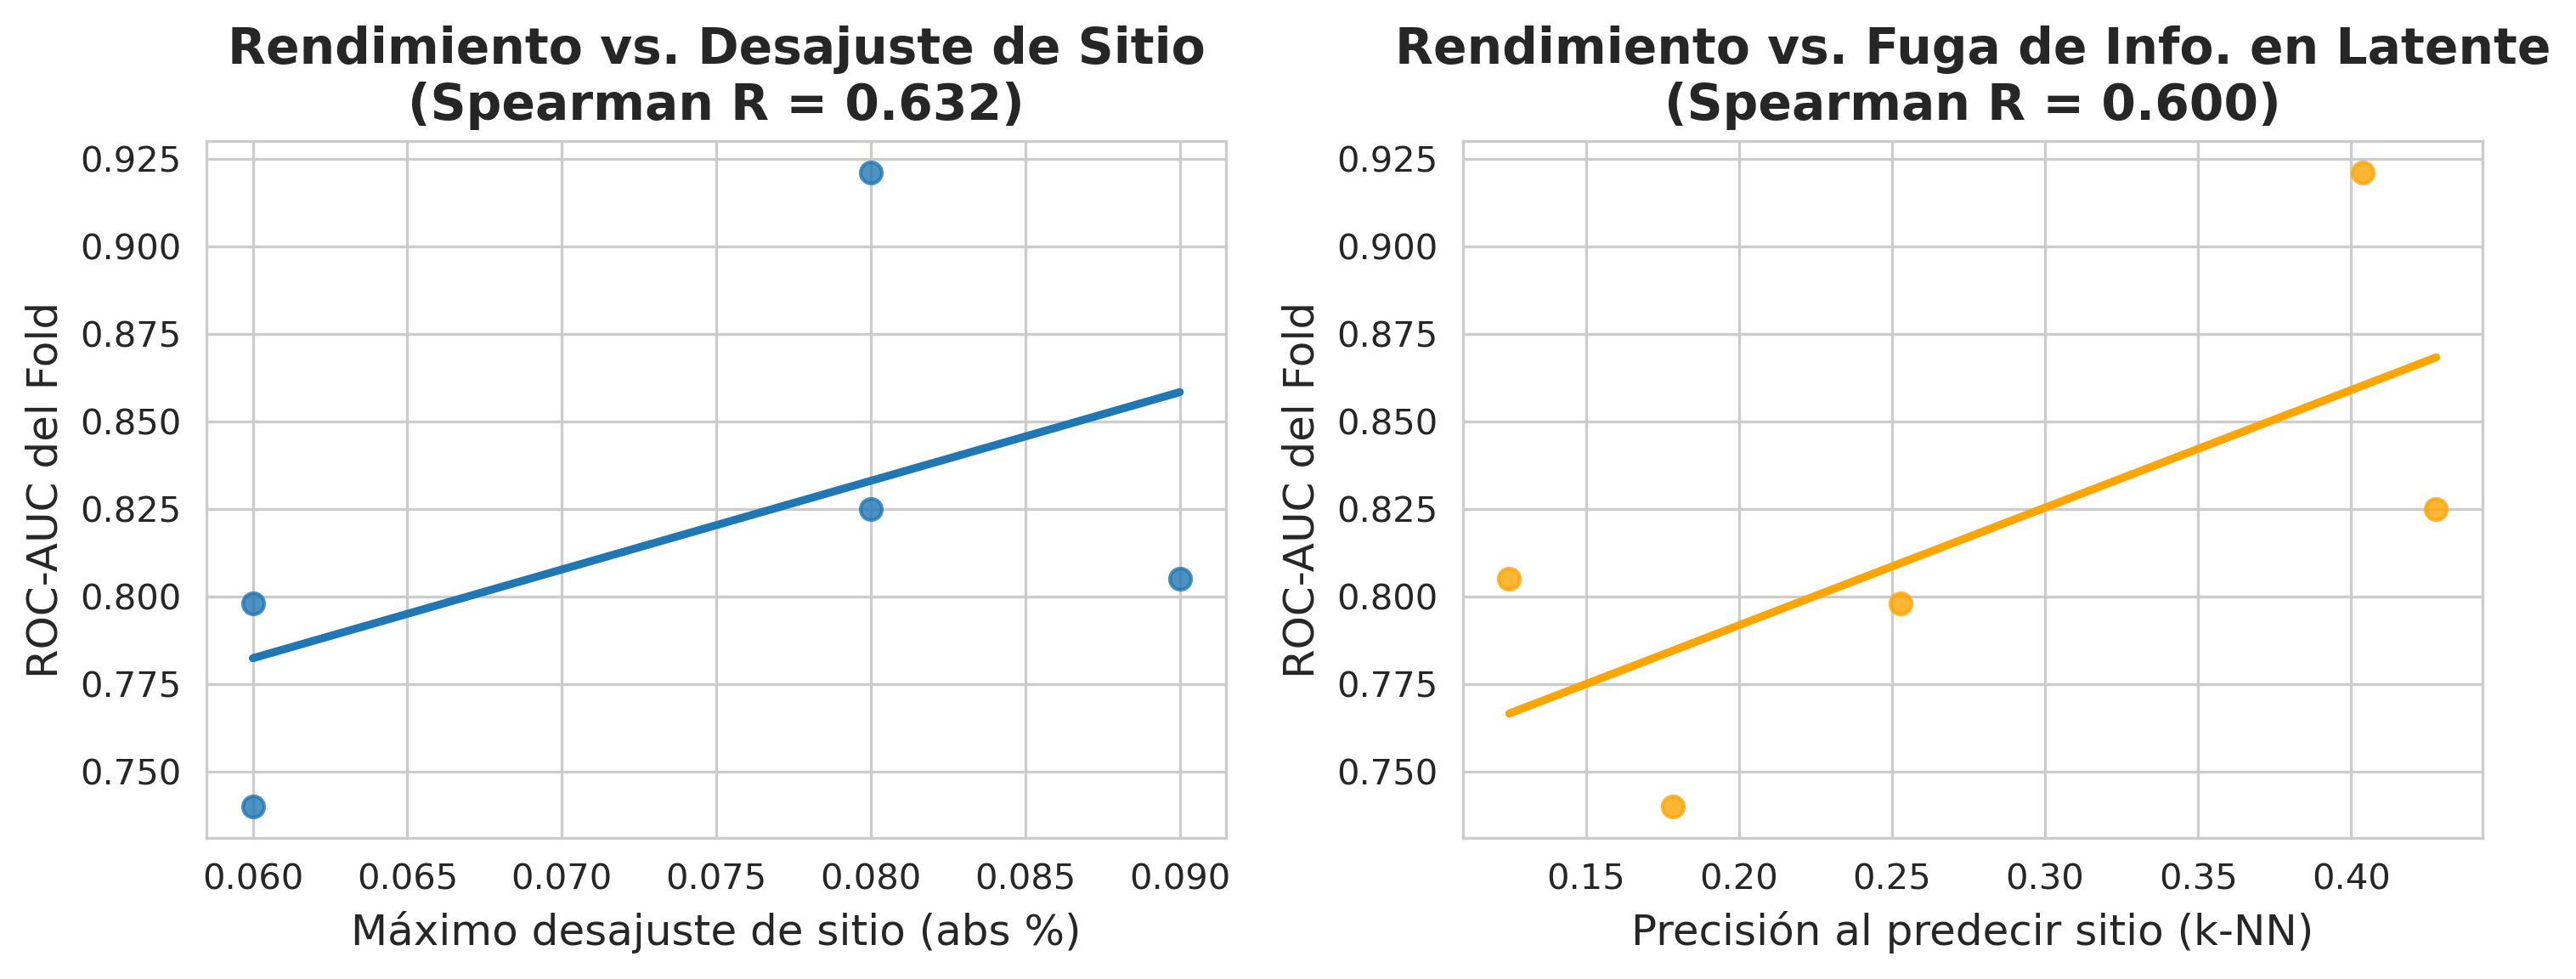

In [13]:
# --- 8. ANÁLISIS DE CORRELACIÓN: DOMAIN SHIFT VS. RENDIMIENTO ---

# Cargar la tabla de rendimiento por fold (de la celda [6])
perf_by_fold_df = perf_df_rounded[perf_df_rounded['Fold'] != 'Pooled'].set_index('Fold')

# Cargar la tabla de domain shift (de la celda [7])
shift_by_fold_df = site_shift_df.set_index('Fold')

# Unir las dos tablas
analysis_df = perf_by_fold_df.join(shift_by_fold_df, lsuffix='_perf', rsuffix='_shift')

# Calcular la correlación de Spearman (más robusta para N=5)
# entre el desajuste del sitio y el AUC.
try:
    # Usar 'Max_site_shift(abs%)' que ya calculaste
    site_shift_col = 'Max_site_shift(abs%)'
    
    # Cargar la tabla de QC latente (de la celda [4])
    qc_latent_df = qc_df.set_index('Fold')
    analysis_df = analysis_df.join(qc_latent_df)

    # Correlacionar AUC con 'Site Shift' y 'Site Accuracy'
    corr_shift = analysis_df['ROC_AUC'].corr(analysis_df[site_shift_col], method='spearman')
    corr_leakage = analysis_df['ROC_AUC'].corr(analysis_df['Confounder Effect (Site Acc.)'], method='spearman')

    print(f"\n--- Correlación (Spearman) entre Rendimiento y Desajustes (N=5) ---")
    print(f"AUC vs. Max Site Shift:     {corr_shift:.3f}")
    print(f"AUC vs. Latent Site Leakage: {corr_leakage:.3f}")

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    sns.regplot(data=analysis_df, x=site_shift_col, y='ROC_AUC', ax=ax1, ci=None)
    ax1.set_title(f'Rendimiento vs. Desajuste de Sitio\n(Spearman R = {corr_shift:.3f})')
    ax1.set_xlabel("Máximo desajuste de sitio (abs %)")
    ax1.set_ylabel("ROC-AUC del Fold")

    sns.regplot(data=analysis_df, x='Confounder Effect (Site Acc.)', y='ROC_AUC', ax=ax2, color='orange', ci=None)
    ax2.set_title(f'Rendimiento vs. Fuga de Info. en Latente\n(Spearman R = {corr_leakage:.3f})')
    ax2.set_xlabel("Precisión al predecir sitio (k-NN)")
    ax2.set_ylabel("ROC-AUC del Fold")
    
    plt.tight_layout()
    plt.savefig(OUTPUT_FIG_DIR / "figure_correlation_shift_vs_auc.pdf", bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"Error al calcular correlación: {e}")
    print("Asegúrate de que las celdas [4], [6], y [7] se hayan ejecutado correctamente.")


--- Cargando Artefactos de QC generados por el Pipeline ---

--- Resumen de Fuga de Escáner (Balanced Accuracy) ---


representation,connectome_norm,latent_mu
fold_tag,,
fold_1,0.149815,0.142411
fold_2,0.135120,0.066846
fold_3,0.153167,0.094167
fold_4,0.104048,0.082698
fold_5,0.159404,0.100096


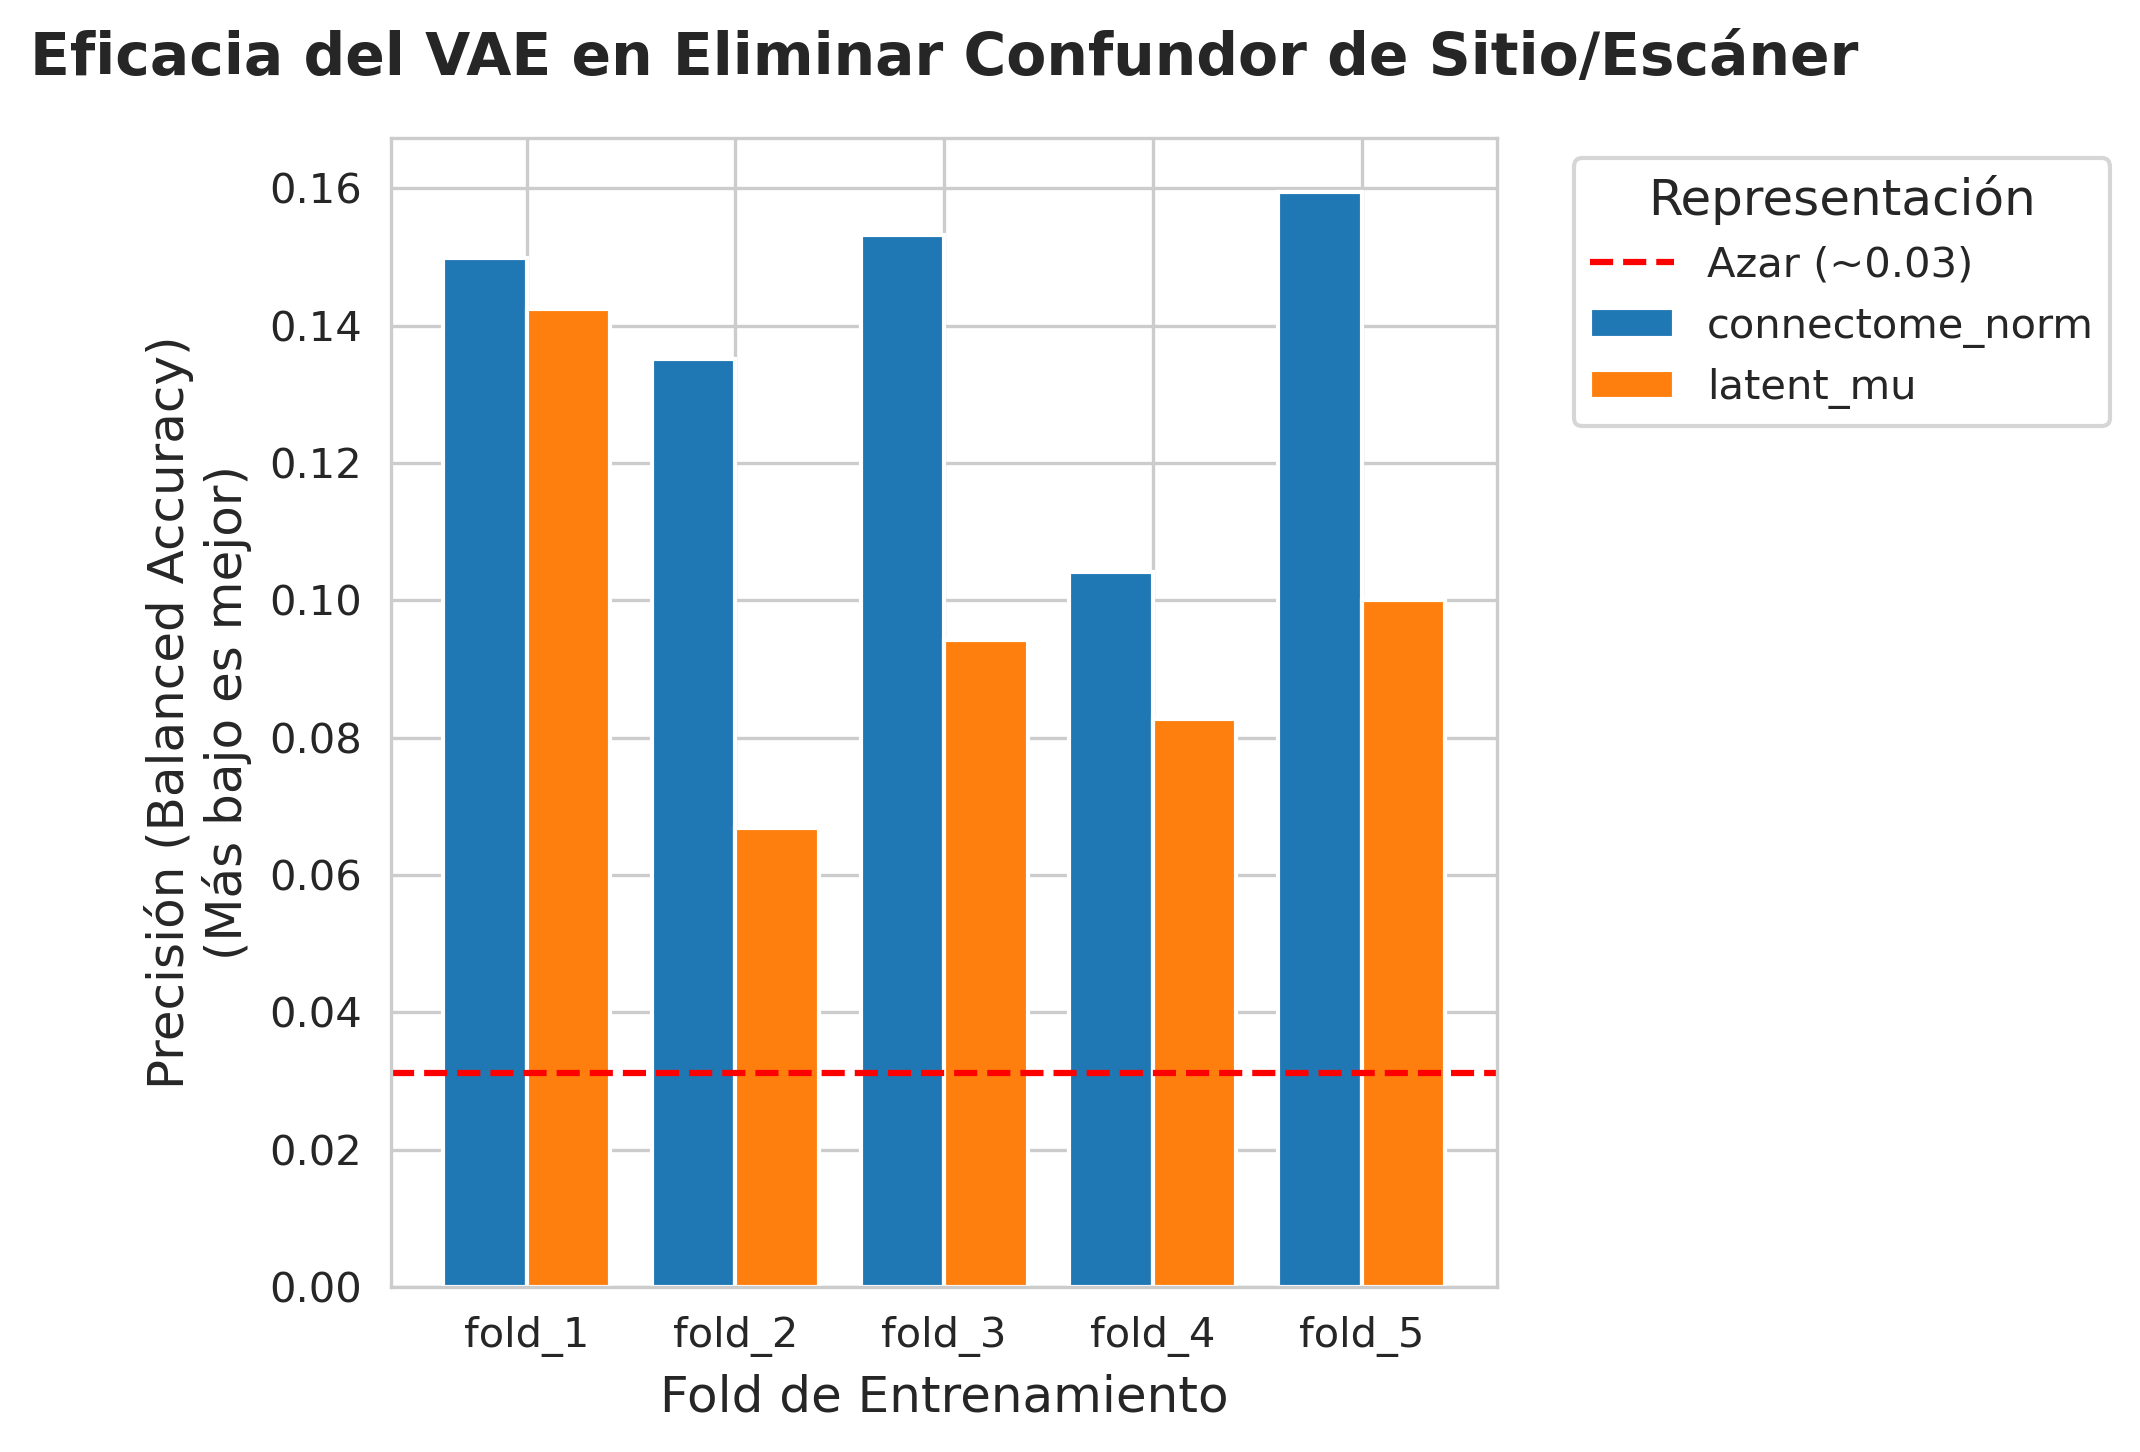


--- Comparación de Varianza (Normalizado vs. Reconstruido) ---


,std_norm,std_recon
channel,,
DistanceCorr,1.0,0.469
MI_KNN_Symmetric,1.0,0.593
Pearson_Full_FisherZ_Signed,1.0,0.659



--- Saturación promedio de 'tanh' (frac > |0.95|) ---


,frac_saturation
channel,
DistanceCorr,0.032
MI_KNN_Symmetric,0.072
Pearson_Full_FisherZ_Signed,0.124


In [14]:
# --- 9. ANÁLISIS DE ARTEFACTOS QC (Validación del Pipeline) ---
print("\n--- Cargando Artefactos de QC generados por el Pipeline ---")

all_qc_dist_raw, all_qc_dist_norm, all_qc_dist_recon = [], [], []
all_qc_leakage = []

for i in range(1, 6):
    fold_dir = RESULTS_DIR / f"fold_{i}"

    # Cargar CSVs de Distribución (RUTAS CORREGIDAS)
    try:
        # Los archivos están en fold_dir, no en un subdirectorio
        df_raw = pd.read_csv(fold_dir / f"fold_{i}_dist_raw.csv")     # <- CORREGIDO
        df_norm = pd.read_csv(fold_dir / f"fold_{i}_dist_norm.csv")   # <- CORREGIDO
        df_recon = pd.read_csv(fold_dir / f"fold_{i}_dist_recon.csv") # <- CORREGIDO
        df_raw['fold'] = i; df_norm['fold'] = i; df_recon['fold'] = i

        all_qc_dist_raw.append(df_raw)
        all_qc_dist_norm.append(df_norm)
        all_qc_dist_recon.append(df_recon)
    except FileNotFoundError:
        print(f"Warning: No se encontraron archivos de QC de distribución en {fold_dir}")

    # Cargar CSVs de Leakage (RUTAS CORREGIDAS)
    try:
        # El archivo está en fold_dir, no en un subdirectorio
        df_leak = pd.read_csv(fold_dir / f"fold_{i}_scanner_leakage.csv") # <- CORREGIDO
        all_qc_leakage.append(df_leak)
    except FileNotFoundError:
        print(f"Warning: No se encontró archivo de QC de leakage en {fold_dir}")

# --- Visualizar Resultados de QC Agregados ---
if all_qc_leakage:
    df_leak_all = pd.concat(all_qc_leakage)
    # Asegurarse de que 'fold_tag' existe, si no, usar 'Fold' o lo que corresponda
    if 'fold_tag' not in df_leak_all.columns:
         df_leak_all['fold_tag'] = [f'fold_{i}' for i in range(1,6) for _ in range(2)] # Asumiendo 2 filas por fold

    df_leak_pivot = df_leak_all.pivot_table(
        index='fold_tag', 
        columns='representation', 
        values='balanced_accuracy_mean'
    )

    print("\n--- Resumen de Fuga de Escáner (Balanced Accuracy) ---")
    display(df_leak_pivot)

    # Plot
    fig, ax = plt.subplots(figsize=(7, 5)) # Ajuste de tamaño
    df_leak_pivot.plot(kind='bar', ax=ax, width=0.8, rot=0) # rot=0 para etiquetas horizontales
    ax.set_title("Eficacia del VAE en Eliminar Confundor de Sitio/Escáner", pad=15) # Más espacio
    ax.set_ylabel("Precisión (Balanced Accuracy)\n(Más bajo es mejor)")
    ax.set_xlabel("Fold de Entrenamiento")
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0) # 'rot=0' en plot() ya lo hace
    ax.axhline(1/df_leak_all['n_classes'].mean(), color='red', ls='--', label=f"Azar (~{1/df_leak_all['n_classes'].mean():.2f})")
    ax.legend(title='Representación', bbox_to_anchor=(1.05, 1), loc='upper left') # Mover leyenda afuera
    plt.tight_layout()
    plt.savefig(OUTPUT_FIG_DIR / "figure_qc_scanner_leakage_summary.pdf", bbox_inches='tight')
    plt.show()

if all_qc_dist_norm:
    df_norm_all = pd.concat(all_qc_dist_norm)
    df_recon_all = pd.concat(all_qc_dist_recon)

    # Comparar Std (norm vs recon)
    std_comp = df_norm_all.groupby('channel')[['std']].mean().rename(columns={'std':'std_norm'})
    std_comp['std_recon'] = df_recon_all.groupby('channel')[['std']].mean()

    print("\n--- Comparación de Varianza (Normalizado vs. Reconstruido) ---")
    display(std_comp.round(3))

    # Comparar Saturación (recon)
    sat_comp = df_recon_all.groupby('channel')[['frac_saturation']].mean()
    print("\n--- Saturación promedio de 'tanh' (frac > |0.95|) ---")
    display(sat_comp.round(3))

In [15]:
def subgroup_perf(df_meta, y_true_global, y_prob_global, group_column):
    # df_meta tiene que estar alineado con y_true_global (orden idéntico)
    # Vamos a convertir AD -> 1 / CN -> 0 igual que antes
    subgroups = df_meta[group_column].dropna().unique()
    rows = []
    for g in subgroups:
        mask = (df_meta[group_column] == g).values
        if mask.sum() < 10 or len(np.unique(y_true_global[mask])) < 2:
            continue  # muy chico o sin los dos clases
        rows.append({
            group_column: g,
            "N": int(mask.sum()),
            "AD_frac": float(y_true_global[mask].mean()),
            "ROC_AUC": roc_auc_score(y_true_global[mask], y_prob_global[mask]),
            "PR_AUC": average_precision_score(y_true_global[mask], y_prob_global[mask]),
            "Brier": brier_score_loss(y_true_global[mask], y_prob_global[mask])
        })
    return pd.DataFrame(rows)

# Necesitamos un meta_df alineado con y_true / y_prob pooled.
# Eso es básicamente el concat de los test_df_fold en el mismo orden en que fuiste apilando all_probs/all_trues.
# Vamos a reconstruirlo:

all_meta_rows = []
for i in range(1,6):
    fold_dir = RESULTS_DIR / f"fold_{i}"
    test_indices = np.load(fold_dir / "test_indices.npy")
    test_df_fold = cn_ad_df.iloc[test_indices].copy()
    all_meta_rows.append(test_df_fold.reset_index(drop=True))
meta_pooled = pd.concat(all_meta_rows, axis=0).reset_index(drop=True)

# Chequeo de alineación
assert len(meta_pooled) == len(y_true), "Desalineación entre metadatos y y_true/y_prob"

# Ejemplo 1: por sexo
meta_pooled['Sex_bin'] = meta_pooled['Sex'].map({'M':'Male','F':'Female'}).fillna('Missing')
sex_perf = subgroup_perf(meta_pooled, y_true, y_prob, 'Sex_bin')
print("\n=== Rendimiento por sexo ===")
display(sex_perf)

# Ejemplo 2: por edad (binaria mediana)
age_med = meta_pooled['Age'].median()
meta_pooled['Age_group'] = np.where(meta_pooled['Age'] >= age_med, f'Older>= {age_med:.1f}', f'Younger< {age_med:.1f}')
age_perf = subgroup_perf(meta_pooled, y_true, y_prob, 'Age_group')
print("\n=== Rendimiento por grupo de edad ===")
display(age_perf)

# Ejemplo 3: por sitio
meta_pooled['site_clean'] = meta_pooled['Site3'].astype(str).fillna('Unknown')
site_perf = subgroup_perf(meta_pooled, y_true, y_prob, 'site_clean').sort_values('N', ascending=False).head(10)
print("\n=== Rendimiento por sitio (top 10 por N) ===")
display(site_perf)

# Podés guardar estas tablas:
sex_perf.to_csv(OUTPUT_FIG_DIR / "table_subgroup_perf_sex.csv", index=False)
age_perf.to_csv(OUTPUT_FIG_DIR / "table_subgroup_perf_age.csv", index=False)
site_perf.to_csv(OUTPUT_FIG_DIR / "table_subgroup_perf_site.csv", index=False)



=== Rendimiento por sexo ===


,Sex_bin,N,AD_frac,ROC_AUC,PR_AUC,Brier
0,Female,92,0.434783,0.821154,0.776693,0.172146
1,Male,92,0.597826,0.793120,0.839763,0.183917



=== Rendimiento por grupo de edad ===


,Age_group,N,AD_frac,ROC_AUC,PR_AUC,Brier
0,Older>= 74.3,92,0.576087,0.802612,0.827936,0.179674
1,Younger< 74.3,92,0.456522,0.806190,0.797455,0.176390



=== Rendimiento por sitio (top 10 por N) ===


,site_clean,N,AD_frac,ROC_AUC,PR_AUC,Brier
3,130,33,0.393939,0.846154,0.746628,0.158747
0,6,14,0.357143,0.644444,0.597222,0.236765
2,100,13,0.153846,0.590909,0.590909,0.149663
4,19,12,0.666667,0.562500,0.708333,0.293897
1,18,10,0.400000,0.625000,0.541667,0.282201


In [16]:
pooled_rows = []
for i in range(1,6):
    fold_dir = RESULTS_DIR / f"fold_{i}"
    test_idx = np.load(fold_dir / "test_indices.npy")
    test_df_fold = cn_ad_df.iloc[test_idx].copy()
    for subj_row, prob, true_ in zip(test_df_fold.itertuples(), all_probs[i-1], all_trues[i-1]):
        pooled_rows.append({
            "Fold": i,
            "SubjectID": getattr(subj_row, "SubjectID", None),
            "tensor_idx": subj_row.tensor_idx,
            "Age": subj_row.Age,
            "Sex": subj_row.Sex,
            "Site3": subj_row.Site3,
            "y_true": int(true_),
            "y_prob": float(prob)
        })

pooled_df = pd.DataFrame(pooled_rows)
pooled_df_path = OUTPUT_FIG_DIR / "pooled_predictions.csv"
pooled_df.to_csv(pooled_df_path, index=False)
pooled_df.head()


,Fold,SubjectID,tensor_idx,Age,Sex,Site3,y_true,y_prob
0,1,002_S_4270,16,74.7,F,2,0,0.042198
1,1,006_S_0498,33,81.9,M,6,0,0.509276
2,1,006_S_4192,39,82.4,M,6,1,0.161884
3,1,006_S_6234,49,70.6,F,6,0,0.083597
4,1,010_S_5163,67,66.6,M,10,1,0.629003


In [17]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, accuracy_score

age_r2_list = []
sex_acc_list = []

for fold_i, df_fold in enumerate(all_fold_data, start=1):
    Z = np.vstack(df_fold['embeddings'].values)
    age = df_fold['Age'].values
    sex = df_fold['Sex'].map({'M':0,'F':1}).fillna(-1).values

    # edad (regresión lineal)
    lin = LinearRegression().fit(Z, age)
    age_pred = lin.predict(Z)
    age_r2 = r2_score(age, age_pred)

    # sexo (clasificación binaria; quitamos -1)
    mask = sex != -1
    if mask.sum() > 5 and len(np.unique(sex[mask])) == 2:
        logreg = LogisticRegression(max_iter=1000).fit(Z[mask], sex[mask])
        sex_pred = logreg.predict(Z[mask])
        sex_acc = accuracy_score(sex[mask], sex_pred)
    else:
        sex_acc = np.nan

    age_r2_list.append(age_r2)
    sex_acc_list.append(sex_acc)

print("Edad R^2 por fold:", age_r2_list)
print("Sexo Acc por fold:", sex_acc_list)
print("Edad R^2 medio:", np.nanmean(age_r2_list))
print("Sexo Acc medio:", np.nanmean(sex_acc_list))


Edad R^2 por fold: [0.9999999999989198, 0.9999999999978684, 0.9999999999988249, 0.9999999999976011, 0.9999999999969698]
Sexo Acc por fold: [1.0, 1.0, 1.0, 1.0, 1.0]
Edad R^2 medio: 0.9999999999980368
Sexo Acc medio: 1.0


In [18]:
# ==============================================================================
# --- CELDA 12 (CORREGIDA): QC Demográfico Latente (Train/Test Split) ---
# ==============================================================================
# Objetivo: ¿La información demográfica (Edad/Sexo) está linealmente
# decodificable en el espacio latente de forma GENERALIZABLE?
#
# Método: Entrenamos un regresor lineal/logístico en el set de TRAIN (N=147)
# y evaluamos su R^2 / Accuracy en el set de TEST (N=37).
# Esto evita el sobreajuste in-sample (N < P) de la celda anterior.
# ==============================================================================

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler

print("\n--- QC: Generalización de Demografía desde Espacio Latente (Train->Test) ---")

age_r2_test_list = []
sex_acc_test_list = []
all_fold_data_train = [] # Necesitaremos los embeddings de train

# --- 1. Recolectar embeddings de TRAIN de cada fold ---
# (Esto es nuevo, antes solo recolectabas TEST)
for i in range(1, 6):
    fold_dir = RESULTS_DIR / f"fold_{i}"
    
    # Cargar VAE y Norm Params (igual que antes)
    vae_model = ConvolutionalVAE(
        input_channels=len(run_args['channels_to_use']), latent_dim=run_args['latent_dim'], image_size=131,
        num_conv_layers_encoder=run_args['num_conv_layers_encoder'], decoder_type=run_args['decoder_type'],
        final_activation=run_args['vae_final_activation'], intermediate_fc_dim_config=run_args['intermediate_fc_dim_vae'],
        dropout_rate=run_args['dropout_rate_vae'], use_layernorm_fc=run_args['use_layernorm_vae_fc']
    ).to(device)
    vae_model.load_state_dict(torch.load(fold_dir / f"vae_model_fold_{i}.pt", map_location=device))
    vae_model.eval()
    norm_params = joblib.load(fold_dir / f"vae_norm_params.joblib")

    # Obtener índices de TRAIN (los que NO están en test)
    all_cn_ad_indices = np.arange(len(cn_ad_df))
    test_indices = np.load(fold_dir / "test_indices.npy")
    train_indices = np.setdiff1d(all_cn_ad_indices, test_indices, assume_unique=True)
    
    df_fold_train = cn_ad_df.iloc[train_indices].copy()
    
    # Generar embeddings para el set de TRAIN
    global_indices_train = df_fold_train['tensor_idx'].values
    tensor_train_orig = global_tensor_data[global_indices_train][:, run_args['channels_to_use'], :, :]
    tensor_train_norm = apply_normalization_params(tensor_train_orig, norm_params)
    
    with torch.no_grad():
        tensor_torch_train = torch.from_numpy(tensor_train_norm).float().to(device)
        mu_train, _ = vae_model.encode(tensor_torch_train)
        df_fold_train['embeddings'] = list(mu_train.cpu().numpy())
    
    all_fold_data_train.append(df_fold_train)


# --- 2. Realizar la evaluación Train -> Test ---
for fold_i, (df_train, df_test) in enumerate(zip(all_fold_data_train, all_fold_data), start=1):
    
    # Datos de TRAIN (N~147)
    Z_train = np.vstack(df_train['embeddings'].values)
    age_train = df_train['Age'].values
    sex_train = df_train['Sex'].map({'M':0,'F':1}).fillna(-1).values
    
    # Datos de TEST (N~37)
    Z_test = np.vstack(df_test['embeddings'].values)
    age_test = df_test['Age'].values
    sex_test = df_test['Sex'].map({'M':0,'F':1}).fillna(-1).values

    # Estandarizar Z (aprendido en train, aplicado a test)
    scaler = StandardScaler().fit(Z_train)
    Z_train_std = scaler.transform(Z_train)
    Z_test_std = scaler.transform(Z_test)

    # --- EDAD (Regresión Lineal) ---
    lin_model = LinearRegression().fit(Z_train_std, age_train)
    age_pred_test = lin_model.predict(Z_test_std)
    age_r2_test = r2_score(age_test, age_pred_test)
    age_r2_test_list.append(age_r2_test)

    # --- SEXO (Regresión Logística) ---
    # Quitar NaNs (-1)
    mask_train = (sex_train != -1)
    mask_test = (sex_test != -1)
    
    if mask_train.sum() > 5 and len(np.unique(sex_train[mask_train])) == 2 and mask_test.sum() > 5:
        log_model = LogisticRegression(max_iter=1000, class_weight='balanced').fit(Z_train_std[mask_train], sex_train[mask_train])
        sex_pred_test = log_model.predict(Z_test_std[mask_test])
        sex_acc_test = accuracy_score(sex_test[mask_test], sex_pred_test)
        sex_acc_test_list.append(sex_acc_test)
    else:
        sex_acc_test_list.append(np.nan)

print("\n--- RESULTADOS QC DEMOGRÁFICO (GENERALIZABLE) ---")
print("Edad R^2 (Test Set):", [round(x, 3) for x in age_r2_test_list])
print("Sexo Acc (Test Set):", [round(x, 3) for x in sex_acc_test_list])
print(f"Edad R^2 medio (Test Set): {np.nanmean(age_r2_test_list):.3f}")
print(f"Sexo Acc medio (Test Set): {np.nanmean(sex_acc_test_list):.3f}")


--- QC: Generalización de Demografía desde Espacio Latente (Train->Test) ---

--- RESULTADOS QC DEMOGRÁFICO (GENERALIZABLE) ---
Edad R^2 (Test Set): [-1.805, -1.576, -0.287, -1.194, -0.273]
Sexo Acc (Test Set): [0.378, 0.703, 0.622, 0.595, 0.583]
Edad R^2 medio (Test Set): -1.027
Sexo Acc medio (Test Set): 0.576
